In [1]:
import os
import pickle

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting (if needed)
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch

from ase.visualize.plot import plot_atoms

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure as PMGStructure
from pymatgen.io.ase import AseAtomsAdaptor

from decifer.utility import pxrd_from_cif

from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties

def get_symbol_patch(latex_input, size=10, center=(0,0), scale=1.0):
    from matplotlib.font_manager import FontProperties
    from matplotlib.textpath import TextPath
    from matplotlib.patches import PathPatch
    from matplotlib.transforms import Affine2D

    # Create a FontProperties object with the desired size
    font_prop = FontProperties(size=size)
    
    # Convert the LaTeX symbol to a TextPath object
    text_path = TextPath(center, latex_input, prop=font_prop)
    
    # Convert the TextPath to a PathPatch object
    patch = PathPatch(text_path, lw=0.01, fc='black')
    
    # Apply a scaling transform to control the patch size in the figure.
    # The 'scale' parameter lets you adjust how large the patch appears.
    patch.set_transform(Affine2D().scale(scale) + patch.get_transform())
    
    return [patch]


def get_compression_arrow(size=0.1, head_length=0.01, center=(0.5, 0.5),
                          mutation_scale=20, color='black'):
    """
    Create a compression arrow composed of three FancyArrowPatch objects.
    
    The compression arrow consists of:
      - A left arrow head pointing inward (rightwards).
      - A shaft (line) connecting the arrow heads.
      - A right arrow head pointing inward (leftwards).
    
    Parameters:
      size : float
          The total horizontal length of the compression arrow.
      head_length : float
          The length of each arrow head.
      center : tuple of float (x, y)
          The center of the arrow.
      mutation_scale : int
          Scale factor for arrow head size.
      color : str
          Color of the arrow.
          
    Returns:
      List of three FancyArrowPatch objects representing the compression arrow.
    """
    cx, cy = center
    left_tip = cx
    right_tip = cx

    # Left arrow head: drawn from left_tip to left_tip + head_length.
    # Using arrowstyle '<-' places the arrow head at the start, i.e. at left_tip, pointing rightwards.
    left_arrow = FancyArrowPatch((left_tip, cy), (left_tip + head_length, cy),
                                 arrowstyle='->', mutation_scale=mutation_scale, color=color)

    # Shaft: a simple line from the end of the left arrow head to the start of the right arrow head.
    shaft = FancyArrowPatch((left_tip, cy), (right_tip + size, cy),
                            arrowstyle='-', mutation_scale=mutation_scale, color=color)

    # Right arrow head: drawn from right_tip to right_tip - head_length.
    # Again, using arrowstyle '<-' places the arrow head at the start (right_tip), 
    # which makes it point leftwards (inward).
    right_arrow = FancyArrowPatch((right_tip + size, cy), (right_tip + size - head_length, cy),
                                  arrowstyle='->', mutation_scale=mutation_scale, color=color)

    return [left_arrow, shaft, right_arrow]

def plot_unit_cell_with_boundaries(structure, ax=None, tol=1e-5, radii=0.8, rotation=('45x, -15y, 90z'), offset=(0, 0, 0)):
    """
    Plots the unit cell along with image atoms from neighboring cells (in the positive x, y, and z directions)
    that are exactly on the unit cell boundary onto a provided axis.
    
    Parameters:
        structure (pymatgen.core.structure.Structure): The input structure.
        ax (matplotlib.axes.Axes): Axis to plot on. If None, a new axis is created.
        tol (float): Tolerance for determining if an atom's fractional coordinate is on the boundary.
        radii (float): Radii for visualizing atoms.
        rotation (tuple or str): Rotation settings for the plot_atoms function.
        
    Returns:
        (ax, discrete_structure): The matplotlib axis containing the plotted structure 
            and the discrete pymatgen Structure constructed.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # Define translation vectors for the original cell and its neighboring cells in the positive directions.
    translation_vectors = [
        [0, 0, 0],  # Original cell
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 1]
    ]
    
    all_species = []
    all_coords = []
    
    # Loop over each translation vector.
    for tv in translation_vectors:
        tv_cart = structure.lattice.get_cartesian_coords(tv)
        for site in structure:
            if tv == [0, 0, 0]:
                # For the original cell, include all atoms.
                all_species.append(site.species_string)
                all_coords.append(site.coords)
            else:
                # For neighboring cells, include only atoms on the cell boundary
                # (i.e. the atom's fractional coordinate is nearly zero in each shifted direction).
                if all(site.frac_coords[i] < tol for i, shift in enumerate(tv) if shift == 1):
                    all_species.append(site.species_string)
                    all_coords.append(site.coords + tv_cart)
    
    all_coords = np.array(all_coords)
    
    # Build a bounding box that encloses the collected atoms.
    min_coords = all_coords.min(axis=0)
    max_coords = all_coords.max(axis=0)
    lattice_vectors = np.diag(max_coords - min_coords)
    
    discrete_structure = PMGStructure(
        lattice=lattice_vectors,
        species=all_species,
        coords=all_coords,
        coords_are_cartesian=True
    )
    
    # Convert the discrete pymatgen structure to an ASE Atoms object and remove periodic boundaries.
    ase_atoms = AseAtomsAdaptor.get_atoms(discrete_structure)
    ase_atoms.set_pbc([False, False, False])
    
    # Plot onto the provided axis.
    plot_atoms(ase_atoms, ax, radii=radii, show_unit_cell=True, rotation=rotation, offset=offset)
    
    return ax, discrete_structure

In [28]:
# Load data
with open('../ablation_results_cubic_crystal_params_comp_2.pkl', "rb") as f:
    data = pickle.load(f)
results = data["results"]
default_params_dict = data["config"]["default_params_dict"]

In [46]:
data["config"]["params_dict"]

{'particle_size': [1, 5, 10, 20, 25, 30, 35, 40, 45, 50, 100],
 'peak_asymmetry': [-1.0,
  -0.75,
  -0.5,
  -0.25,
  -0.1,
  0.0,
  0.1,
  0.25,
  0.5,
  0.75,
  1.0],
 'q_shift': [-0.5, -0.25, -0.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.25, 0.5],
 'q_scale': [0.8, 0.9, 0.95, 0.975, 0.99, 1.0, 1.01, 1.025, 1.05, 1.1, 1.2],
 'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'noise': [0.0, 0.01, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2],
 'base_fwhm': [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4]}

In [3]:
# # Define your list of parameter dictionaries.
# param_keys = [
#     {"key": "q_shift", "xlabel": "Peak Shift", "unit": r"$_{\;[Å^{-1}]}$", "example_1_idx": 2, "example_2_idx": 8},
#     {"key": "q_scale",  "xlabel": "Peak Scale Factor", "unit": "", "example_1_idx": 3, "example_2_idx": 7},
#     {"key": "peak_asymmetry", "xlabel": "Peak Assymetry Factor", "unit": "", "example_1_idx": 0, "example_2_idx": 10},
#     {"key": "particle_size", "xlabel": "Crystallite Size", "unit": r"$_{\;[Å]}$", "example_1_idx": 1, "example_2_idx": 8},
#     {"key": "eta", "xlabel": "Mixture Coefficient", "unit": "", "example_1_idx": 1, "example_2_idx": 8},
#     {"key": "noise", "xlabel": "Additive Noise", "unit": "%", "example_1_idx": 1, "example_2_idx": 10},
#     # {"key": "base_fwhm", "xlabel": "Instrumental Broadening", "unit": "", "example_1_idx": 1, "example_2_idx": 6},
# ]

# # Colors
# c_ex1 = "k"#"C1"
# c_ex2 = "k"#"C2"
# c_pred1 = "C3"#"grey"
# c_pred2 = "C3"#"grey"
# c_trend = "k"#"C3"

# # Other
# pred_marker_size = 3
# fig_width_factor = 3

# n_params = len(param_keys)
# # Create a subplot grid with 3 rows:
# # Row 0: main plot; Row 1: trend plot; Rows 2: unit cell plots for example A
# # Use height_ratios so that rows 2 and 3 are half the height of rows 0 and 1.
# fig, axes = plt.subplots(4, n_params, figsize=(fig_width_factor * n_params, 10), squeeze=False,
#                           sharey='row', gridspec_kw={'height_ratios': [1, 1, 0.25, 0.7]})

# for i, param in enumerate(param_keys):
#     param_key = param["key"]
#     param_key_xlabel = param["xlabel"]
#     param_key_unit = param["unit"]

#     param_val_keys = list(results[param_key].keys())
#     example_1_idx = param["example_1_idx"]
#     example_2_idx = param["example_2_idx"]
#     example_1_key = param_val_keys[example_1_idx]
#     example_2_key = param_val_keys[example_2_idx]
    
#     # --- Top subplot: main plot for current parameter.
#     ax = axes[0, i]
#     # Extract data for example 1 (A)
#     q_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
#     iq_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
#     q_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
#     iq_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
#     # Extract data for example 2 (B)
#     q_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
#     iq_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
#     q_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
#     iq_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
#     peak_scaling = 0.8
#     ax.plot(q_1, iq_1 * peak_scaling, lw=1, c=c_ex1, label='input')
#     ax.plot(q_100, iq_100 * peak_scaling - 1, lw=1, c=c_ex2)
    
#     #ax.bar(q_1_disc, iq_1_disc / 100 * peak_scaling, width=pred_width, color=c_pred1, zorder=10, label='pred. 1', hatch='..', edgecolor='none')
#     #ax.bar(q_100_disc, iq_100_disc / 100 * peak_scaling, bottom=-1, width=pred_width, color=c_pred2, zorder=10, label='pred. 2', hatch='..', edgecolor='none')

#     stem = ax.stem(q_1_disc,  iq_1_disc / 100 * peak_scaling, linefmt=f'{c_pred1}-', markerfmt=f'{c_pred1}o', basefmt=' ', label='prediction')  # 'k' for black color
#     stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=1.0)
#     stem.markerline.set_xdata(q_1_disc)

#     stem = ax.stem(q_100_disc, iq_100_disc / 100 * peak_scaling - 1, linefmt=f'{c_pred2}-', markerfmt=f'{c_pred2}o', basefmt=' ', bottom=-1)  # 'k' for black color
#     stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred2}', markeredgewidth=1.0)
#     stem.markerline.set_xdata(q_100_disc)
    
#     ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3,
#                 frameon=False, columnspacing=0.0, handletextpad=0.15)
    
#     ax.grid(alpha=0.2)
#     ax.set(
#         yticklabels=[],
#         xlabel=r"$Q_{\;[Å^{-1}]}$",
#         ylabel=r"$I(Q)_{\;[a.u.]}$" if i == 0 else "",
#         ylim=(-1.05, None),
#         xlim=(1, 8),
#     )

#     ax.set_title(param_key_xlabel, pad=20.0, fontsize=12)
    
#     ax.text(1.5, 0.5, "A", ha='center', va='top', fontsize=12, color='black',
#             path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax.text(1.5, -0.5, "B", ha='center', va='top', fontsize=12, color='black',
#             path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
#     # --- Second subplot: trend plot for current parameter.
#     ax_t = axes[1, i]
#     min_rwps = np.array([results[param_key][key]["best_experiment"]["rwp"] for key in param_val_keys])
#     mean_rwps = np.array([np.mean([l["rwp"] for l in results[param_key][key]["experiments"]])
#                             for key in param_val_keys])
#     std_rwps = np.array([np.std([l["rwp"] for l in results[param_key][key]["experiments"]])
#                            for key in param_val_keys])
    
#     ax_t.plot(param_val_keys, mean_rwps, label=r"$\mu \pm 1\sigma$", color=c_trend)
#     ax_t.scatter(param_val_keys, min_rwps, label="$\mathrm{min}(R_{\mathrm{wp}})$", color=c_trend, s=10, fc='white', zorder=10)
#     ax_t.fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps,
#                       color=c_trend, alpha=0.2, ec='none')
    
#     ax_t.axvline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5) 
#     ax_t.axvline(example_2_idx, c='k', lw=1,ls='--', alpha=0.5) 
#     ax_t.grid(alpha=0.2, which='major')
    
#     letter_pos = 0.2
#     y_top = ax_t.get_ylim()[1]
#     ax_t.text(example_1_idx, y_top * letter_pos, "A", ha='center', va='top', fontsize=12, color='black',
#               path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax_t.text(example_2_idx, y_top * letter_pos, "B", ha='center', va='top', fontsize=12, color='black',
#               path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
#     ax_t.set(
#         ylabel=r'$R_{\mathrm{wp}}$' if i == 0 else "",
#         xlabel=f'{param_key_xlabel}{param_key_unit}'
#     )
#     ax_t.set_xticks(list(param_val_keys))
#     ax_t.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
#     ax_t.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.175), ncol=2,
#                 frameon=False, columnspacing=0.0, handletextpad=0.15)
    
#     # --- Third subplot (new row): Horizontal boxplots of combined cell side lengths for current parameter.
#     ax_box = axes[2, i]
    
#     # Gather cell side lengths from all experiments for both structures.
#     # For structure A:
#     experiments_A = results[param_key][example_1_key]["experiments"]
#     cell_params_A = np.array([exp["generated_structure"].lattice.abc for exp in experiments_A])
#     data_A = cell_params_A.flatten()  # Combine a, b, and c values
    
#     # For structure B:
#     experiments_B = results[param_key][example_2_key]["experiments"]
#     cell_params_B = np.array([exp["generated_structure"].lattice.abc for exp in experiments_B])
#     data_B = cell_params_B.flatten()  # Combine a, b, and c values
    
#     # Create a horizontal boxplot with two boxes: one for structure A and one for structure B.
#     data = [data_B, data_A]
#     labels = ["B", "A"]
#     bp = ax_box.boxplot(data, widths=0.5, patch_artist=True, showfliers=False, vert=False)
    
#     # Color the boxplots in greyscale: dark grey for A and light grey for B.
#     colors = ['0.3', '0.7']
#     handles = []  # Store legend handles explicitly
    
#     for j, box in enumerate(reversed(bp['boxes'])):
#         box.set(facecolor=colors[j])
#         handles.append(box)  # Collect handles in reversed order
    
#     # For horizontal boxplots, set y-ticks to label the two groups.
#     ax_box.set_yticks([])
#     ax_box.set_yticklabels([])

#     # Compute reference means for each structure using the best experiment's generated structure.
#     ref_structure_A = results[param_key][example_1_key]["best_experiment"]["reference_structure"]
#     ref_cell_A = np.array(ref_structure_A.lattice.abc)
#     ref_mean_A = ref_cell_A.mean()
    
#     ref_structure_B = results[param_key][example_2_key]["best_experiment"]["reference_structure"]
#     ref_cell_B = np.array(ref_structure_B.lattice.abc)
#     ref_mean_B = ref_cell_B.mean()
    
#     # Draw dotted vertical lines for the reference means.
#     hline = ax_box.axvline(ref_mean_A, color=colors[0], linestyle=':', linewidth=1, c='C3', label='ref.')
#     handles.append(hline)
#     ax_box.axvline(ref_mean_B, color=colors[1], linestyle=':', linewidth=1, c='C3')

#     ax_box.set_xlabel(r"Cell Length Prediction$_{\;[Å]}$")
#     ax_box.grid(alpha=0.2)
    
#     # Ensure A appears before B in the legend
#     ax_box.legend(handles=handles, labels=['A', 'B', 'ref.'], fontsize=9, loc='upper center',
#                   bbox_to_anchor=(0.5, 1.6), ncol=3, frameon=False, columnspacing=1.0, handletextpad=0.25)
    
#     # --- Fourth subplot (shifted down): Unit cell plot including both mean structures A and B.
#     # For structure A, select from all experiments using the mean rwp.
#     rwp_values_A = np.array([exp["rwp"] for exp in experiments_A])
#     mean_rwp_A = np.mean(rwp_values_A)
#     closest_idx_A = np.argmin(np.abs(rwp_values_A - mean_rwp_A))
#     structure_A = experiments_A[closest_idx_A]["generated_structure"]
    
#     # For structure B, similarly select the experiment closest to the mean rwp.
#     rwp_values_B = np.array([exp["rwp"] for exp in experiments_B])
#     mean_rwp_B = np.mean(rwp_values_B)
#     closest_idx_B = np.argmin(np.abs(rwp_values_B - mean_rwp_B))
#     structure_B = experiments_B[closest_idx_B]["generated_structure"]
    
#     ax_cell = axes[3, i]
#     # Plot structure A with no offset.
#     ax_cell, discrete_structure_A = plot_unit_cell_with_boundaries(structure_A, ax=ax_cell)
    
#     # Compute an offset for structure B based on structure A's lattice parameter.
#     a_A, _, _ = discrete_structure_A.lattice.abc
#     offset_B = (a_A * 2, 0, 0)
    
#     # Plot structure B on the same axis with the computed offset.
#     ax_cell, discrete_structure_B = plot_unit_cell_with_boundaries(structure_B, ax=ax_cell, offset=offset_B)
    
#     # Add text labels at appropriate data coordinates.
#     ax_cell.text(0, 0, r"$\overline{\mathbf{A}}$", fontsize=12, fontweight='bold', color='black',
#                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax_cell.text(offset_B[0], 0,  r"$\overline{\mathbf{B}}$", fontsize=12, fontweight='bold', color='black',
#                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
#     ax_cell.set_ylim(-2, discrete_structure_B.cart_coords.max()*2)
#     ax_cell.axis("off")

# fig.subplots_adjust(hspace=0.6, wspace=0.1)

# # Shift the third row
# for ax in axes[2]:
#     pos = ax.get_position()
#     ax.set_position([pos.x0, pos.y0 - 0.025, pos.width, pos.height])

# fig.savefig("the_figure.png", dpi=300, bbox_inches='tight')
# plt.show()


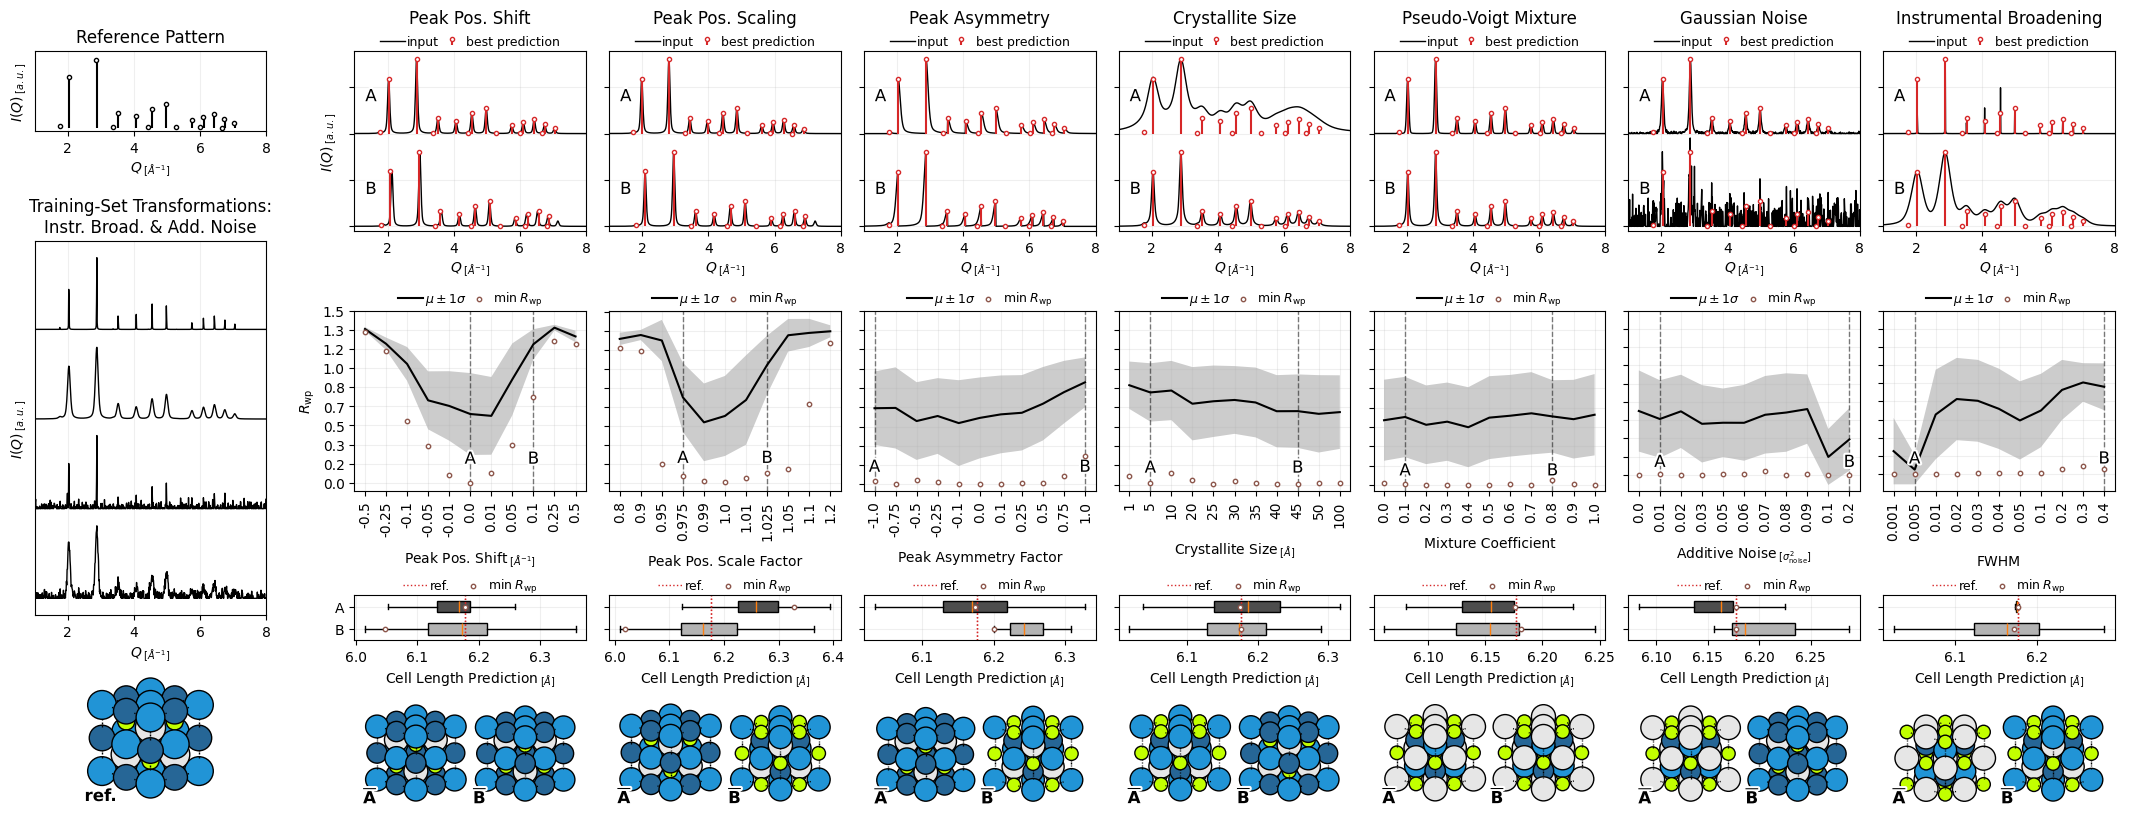

In [52]:
# Define your list of parameter dictionaries.
compression_args = dict(size=0.3, head_length=0.001, mutation_scale=10, color='black')

param_keys = [
    {
        "key": "q_shift", 
        "title": "Peak Pos. Shift", 
        "xlabel": "Peak Pos. Shift", 
        "unit": r"$_{\;[Å^{-1}]}$", 
        "example_1_idx": 5, 
        "example_2_idx": 8,
        "param_symbol_top": r"$\lhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\rhd\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "q_scale", 
        "title": "Peak Pos. Scaling", 
        "xlabel": "Peak Pos. Scale Factor", 
        "unit": "", 
        "example_1_idx": 3, 
        "example_2_idx": 7,
        "param_symbol_top": r"$\rhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\lhd\;\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "peak_asymmetry", 
        "title": "Peak Asymmetry", 
        "xlabel": "Peak Asymmetry Factor", 
        "unit": "", 
        "example_1_idx": 0, 
        "example_2_idx": 10,
        "param_symbol_top": r"$/\!|$",
        "param_symbol_top_rot": 18.5,
        "param_symbol_bot": r"$|\!\backslash$",
        "param_symbol_bot_rot": -18.5,
        "param_symbol_size": 20
    },
    {
        "key": "particle_size", 
        "title": "Crystallite Size", 
        "xlabel": "Crystallite Size", 
        "unit": r"$_{\;[Å]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 8,
        "param_symbol_top": r"o",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "eta", 
        "title": "Pseudo-Voigt Mixture", 
        "xlabel": "Mixture Coefficient", 
        "unit": "", 
        "example_1_idx": 1, 
        "example_2_idx": 8,
        "param_symbol_top": r"$\cap$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\prec$",
        "param_symbol_bot_rot": -90,
        "param_symbol_size": 12
    },
    {
        "key": "noise", 
        "title": "Gaussian Noise", 
        "xlabel": "Additive Noise", 
        "unit": r"$_{\;[\sigma_{\mathrm{noise}}^2]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 10,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "base_fwhm", 
        "title": "Instrumental Broadening", 
        "xlabel": "FWHM", 
        "unit": "", 
        "example_1_idx": 1, 
        "example_2_idx": 10,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    
    # {"key": "base_fwhm", "xlabel": "Instrumental Broadening", "unit": "", "example_1_idx": 1, "example_2_idx": 6},
]

# Colors
c_ex1 = "k"#"C1"
c_ex2 = "k"#"C2"
c_pred1 = "C3"#"grey"
c_pred2 = "C3"#"grey"
c_trend = "k"#"C3"
c_min = "C5"

# Other
pred_marker_size = 3
fig_width_factor = 3.25

n_params = len(param_keys)
# Create a subplot grid with 3 rows:
# Row 0: main plot; Row 1: trend plot; Rows 2: unit cell plots for example A
# Use height_ratios so that rows 2 and 3 are half the height of rows 0 and 1.
fig, axes = plt.subplots(4, n_params + 1, figsize=(fig_width_factor * (n_params + 1), 10), squeeze=False,
                          gridspec_kw={'height_ratios': [1, 1, 0.25, 0.7]}) # sharey='row'

for i, param in enumerate(param_keys):
    param_key = param["key"]
    param_key_title = param["title"]
    param_key_xlabel = param["xlabel"]
    param_key_unit = param["unit"]
    param_symbol_top = param["param_symbol_top"]
    param_symbol_top_rot = param["param_symbol_top_rot"]
    param_symbol_bot = param["param_symbol_bot"]
    param_symbol_bot_rot = param["param_symbol_bot_rot"]
    param_symbol_size = param["param_symbol_size"]

    param_val_keys = list(results[param_key].keys())
    example_1_idx = param["example_1_idx"]
    example_2_idx = param["example_2_idx"]
    example_1_key = param_val_keys[example_1_idx]
    example_2_key = param_val_keys[example_2_idx]
    
    # --- Top subplot: main plot for current parameter.
    ax = axes[0, i + 1]
    # Extract data for example 1 (A)
    q_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
    # Extract data for example 2 (B)
    q_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
    peak_scaling = 0.8
    ax.plot(q_1, iq_1 * peak_scaling, lw=1, c=c_ex1, label='input')
    ax.plot(q_100, iq_100 * peak_scaling - 1, lw=1, c=c_ex2)

    stem = ax.stem(q_1_disc,  iq_1_disc / 100 * peak_scaling, linefmt=f'{c_pred1}-', markerfmt=f'{c_pred1}o', basefmt=' ', label='best prediction')  # 'k' for black color
    stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=1.0)
    stem.markerline.set_xdata(q_1_disc)

    stem = ax.stem(q_100_disc, iq_100_disc / 100 * peak_scaling - 1, linefmt=f'{c_pred2}-', markerfmt=f'{c_pred2}o', basefmt=' ', bottom=-1)  # 'k' for black color
    stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred2}', markeredgewidth=1.0)
    stem.markerline.set_xdata(q_100_disc)
    
    ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3,
                frameon=False, columnspacing=0.0, handletextpad=0.15)
    
    ax.grid(alpha=0.2)
    ax.set(
        yticklabels=[],
        xlabel=r"$Q_{\;[Å^{-1}]}$",
        ylabel=r"$I(Q)_{\;[a.u.]}$" if i == 0 else "",
        ylim=(-1.05, None),
        xlim=(1, 8),
    )

    ax.set_title(param_key_title, pad=20.0, fontsize=12)
    
    ax.text(1.5, 0.5, "A", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax.text(1.5, -0.5, "B", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

    # ax.text(7.0, 0.5, param_symbol_top, ha='center', va='top', fontsize=param_symbol_size, color='black', rotation=param_symbol_top_rot,
    #         path_effects=[path_effects.withStroke(linewidth=0.0, foreground='black')])
    # ax.text(7.0, -0.5, param_symbol_bot, ha='center', va='top', fontsize=param_symbol_size, color='black', rotation=param_symbol_bot_rot,
    #         path_effects=[path_effects.withStroke(linewidth=0.0, foreground='black')])
    
    # --- Second subplot: trend plot for current parameter.
    ax_t = axes[1, i + 1]
    min_rwps = np.array([results[param_key][key]["best_experiment"]["rwp"] for key in param_val_keys])
    mean_rwps = np.array([np.mean([l["rwp"] for l in results[param_key][key]["experiments"]])
                            for key in param_val_keys])
    std_rwps = np.array([np.std([l["rwp"] for l in results[param_key][key]["experiments"]])
                           for key in param_val_keys])
    
    ax_t.plot(param_val_keys, mean_rwps, label=r"$\mu \pm 1\sigma$", color=c_trend)
    ax_t.scatter(param_val_keys, min_rwps, label="$\mathrm{min}\;R_{\mathrm{wp}}$", color=c_min, s=10, fc='white', zorder=10)
    ax_t.fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps,
                      color=c_trend, alpha=0.2, ec='none')
    
    ax_t.axvline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5) 
    ax_t.axvline(example_2_idx, c='k', lw=1,ls='--', alpha=0.5) 
    ax_t.grid(alpha=0.2, which='major')
    
    letter_pos = 0.2
    y_top = ax_t.get_ylim()[1]
    ax_t.text(example_1_idx, y_top * letter_pos, "A", ha='center', va='top', fontsize=12, color='black',
              path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax_t.text(example_2_idx, y_top * letter_pos, "B", ha='center', va='top', fontsize=12, color='black',
              path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_t.set_ylabel(r'$R_{\mathrm{wp}}$' if i == 0 else "")
    ax_t.set_xlabel(f'{param_key_xlabel}{param_key_unit}', labelpad=10.0)
    ax_t.set_xticks(list(param_val_keys))
    ax_t.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
    ax_t.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.175), ncol=2,
                frameon=False, columnspacing=0.0, handletextpad=0.15)
    
    # --- Third subplot (new row): Horizontal boxplots of combined cell side lengths for current parameter.
    ax_box = axes[2, i + 1]
    
    # Gather cell side lengths from all experiments for both structures.
    # For structure A:
    experiments_A = results[param_key][example_1_key]["experiments"]
    cell_params_A = np.array([exp["generated_structure"].lattice.abc for exp in experiments_A])
    data_A = cell_params_A.flatten()  # Combine a, b, and c values

    # Best cell params in A
    best_cell_params_A = results[param_key][example_1_key]["best_experiment"]["generated_structure"].lattice.abc
    mean_best_data_A = np.mean(best_cell_params_A)
    
    # For structure B:
    experiments_B = results[param_key][example_2_key]["experiments"]
    cell_params_B = np.array([exp["generated_structure"].lattice.abc for exp in experiments_B])
    data_B = cell_params_B.flatten()  # Combine a, b, and c values

    # Best cell params in B
    best_cell_params_B = results[param_key][example_2_key]["best_experiment"]["generated_structure"].lattice.abc
    mean_best_data_B = np.mean(best_cell_params_B)
    
    # Create a horizontal boxplot with two boxes: one for structure A and one for structure B.
    data = [data_B, data_A]
    labels = ["B", "A"]
    bp = ax_box.boxplot(data, widths=0.5, patch_artist=True, showfliers=False, vert=False)
    
    # Color the boxplots in greyscale: dark grey for A and light grey for B.
    colors = ['0.3', '0.7']
    handles = []  # Store legend handles explicitly
    
    for j, box in enumerate(reversed(bp['boxes'])):
        box.set(facecolor=colors[j])
    #     handles.append(box)  # Collect handles in reversed order
    
    # For horizontal boxplots, set y-ticks to label the two groups.
    if i + 1 == 1:
        ax_box.set_yticks([1,2])
        ax_box.set_yticklabels(["B", "A"])
    else:
        ax_box.set_yticks([1,2])
        ax_box.set_yticklabels([])

    # Compute reference means for each structure using the best experiment's generated structure.
    ref_structure_A = results[param_key][example_1_key]["best_experiment"]["reference_structure"]
    ref_cell_A = np.array(ref_structure_A.lattice.abc)
    ref_mean_A = ref_cell_A.mean()
    
    ref_structure_B = results[param_key][example_2_key]["best_experiment"]["reference_structure"]
    ref_cell_B = np.array(ref_structure_B.lattice.abc)
    ref_mean_B = ref_cell_B.mean()
    
    # Draw dotted vertical lines for the reference means.
    hline = ax_box.axvline(ref_mean_A, color=colors[0], linestyle=':', linewidth=1, c='C3')
    handles.append(hline)
    ax_box.axvline(ref_mean_B, color=colors[1], linestyle=':', linewidth=1, c='C3')

    # Add mean of bests
    mbA = ax_box.scatter(x=mean_best_data_A, y=2, ec=c_min, zorder=10, s=10, fc='white')
    ax_box.scatter(x=mean_best_data_B, y=1, ec=c_min, zorder=10, s=10, fc='white')
    handles.append(mbA)
    
    ax_box.set_xlabel(r"Cell Length Prediction$_{\;[Å]}$")
    ax_box.grid(alpha=0.2)

    # Ensure A appears before B in the legend
    ax_box.legend(handles=handles, labels=['ref.', r"$\mathrm{min}\;R_{\mathrm{wp}}$"], fontsize=9, loc='upper center',
                  bbox_to_anchor=(0.5, 1.65), ncol=4, frameon=False, columnspacing=0.85, handletextpad=0.15)
    
    # --- Fourth subplot (shifted down): Unit cell plot including both mean structures A and B.
    # For structure A, select from all experiments using the mean rwp.
    rwp_values_A = np.array([exp["rwp"] for exp in experiments_A])
    mean_rwp_A = np.mean(rwp_values_A)
    closest_idx_A = np.argmin(np.abs(rwp_values_A - mean_rwp_A))
    structure_A = experiments_A[closest_idx_A]["generated_structure"]
    
    # For structure B, similarly select the experiment closest to the mean rwp.
    rwp_values_B = np.array([exp["rwp"] for exp in experiments_B])
    mean_rwp_B = np.mean(rwp_values_B)
    closest_idx_B = np.argmin(np.abs(rwp_values_B - mean_rwp_B))
    structure_B = experiments_B[closest_idx_B]["generated_structure"]
    
    ax_cell = axes[3, i + 1]
    # Plot structure A with no offset.
    ax_cell, discrete_structure_A = plot_unit_cell_with_boundaries(structure_A, ax=ax_cell)
    
    # Compute an offset for structure B based on structure A's lattice parameter.
    a_A, _, _ = discrete_structure_A.lattice.abc
    offset_B = (a_A * 2, 0, 0)
    
    # Plot structure B on the same axis with the computed offset.
    ax_cell, discrete_structure_B = plot_unit_cell_with_boundaries(structure_B, ax=ax_cell, offset=offset_B)
    
    # Add text labels at appropriate data coordinates.
    ax_cell.text(0, 0, r"$\overline{\mathbf{A}}$", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax_cell.text(offset_B[0], 0,  r"$\overline{\mathbf{B}}$", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_cell.set_ylim(-2, discrete_structure_B.cart_coords.max()*2)
    ax_cell.axis("off")

fig.subplots_adjust(hspace=0.6, wspace=0.1)

# yticks for Rwp
for ax in axes[1,1:]:
    ax.set_yticks(np.linspace(0,1.5,10))
    ax.set_yticklabels([])
axes[1,1].set_yticks(np.linspace(0,1.5,10))
axes[1,1].set_yticklabels(["{:.1f}".format(e) for e in np.linspace(0,1.5,10)])

# Shift the third row
for ax in axes[2]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 - 0.025, pos.width, pos.height])

# Reference shift
ref_shift = 0.025

# Shift the new left column further to the left
for row in range(4):
    ax = axes[row, 0]
    pos = ax.get_position()
    # Adjust the x0 position to shift left by 0.05 (adjust value as needed)
    ax.set_position([pos.x0 - 0.05, pos.y0, pos.width, pos.height])

# Combine rows 2 and 3 for the left column into a single axis.
# Get the gridspec from one of the left column axes.
gs = axes[0, 0].get_gridspec()

# Remove the existing left column axes for rows 2 and 3.
for ax in axes[:, 0]:
    ax.remove()

ax_p = fig.add_subplot(gs[0,0])

# Create a new axis spanning rows 2 and 3 in the first column.
ax_ref_struc = fig.add_subplot(gs[-1, 0])
    
pos = ax_ref_struc.get_position()
ax_ref_struc.set_position([pos.x0 - ref_shift, pos.y0 + 0.02, pos.width, pos.height])

# Add reference structure to ax_ref_struc
ax_ref_struc, _ = plot_unit_cell_with_boundaries(ref_structure_A, ax=ax_ref_struc, offset=(0,0,0))
ax_ref_struc.text(0, 0, "ref.", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
ax_ref_struc.axis("off")

ax_p.set_title("Reference Pattern", fontsize=12)

param_val_keys = list(results[param_keys[0]["key"]].keys())
q_ref_disc = results[param_keys[0]["key"]][param_val_keys[param_keys[0]["example_1_idx"]]]["best_experiment"]["pxrd_ref_clean"]["q_disc"][0]
iq_ref_disc = results[param_keys[0]["key"]][param_val_keys[param_keys[0]["example_2_idx"]]]["best_experiment"]["pxrd_ref_clean"]["iq_disc"][0]

peak_scaling = 0.8
stem = ax_p.stem(q_ref_disc, iq_ref_disc / 100 * peak_scaling, linefmt=f'{c_trend}-', markerfmt=f'{c_trend}o', basefmt=' ')
stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_trend}', markeredgewidth=1.0)
stem.markerline.set_xdata(q_ref_disc - 0.01)
pos = ax_p.get_position()
ax_p.set_position([pos.x0 - ref_shift, pos.y0 + 0.1, pos.width, pos.height - 0.1])
ax_p.set(
    yticks=[],
    yticklabels=[],
    xlim=(1,8),
    ylim=(None, peak_scaling+0.1),
    ylabel=r"$I(Q)_{\;[a.u.]}$",
    xlabel=r"$Q_{\;[Å^{-1}]}$",
)
ax_p.grid(alpha=0.2)

ax_ref_trans = fig.add_subplot(gs[1:-1, 0])
pos = ax_ref_trans.get_position()
ax_ref_trans.set_position([pos.x0 - ref_shift, pos.y0, pos.width, pos.height + 0.07])
ax_ref_trans.set(
    yticks=[],
    yticklabels=[],
    xlim=(1,8),
    ylabel=r"$I(Q)_{\;[a.u.]}$",
    xlabel=r"$Q_{\;[Å^{-1}]}$",
)
ax_ref_trans.grid(alpha=0.2)
ax_ref_trans.set_title("Training-Set Transformations:\nInstr. Broad. & Add. Noise")

# Calculate PXRD from reference
pxrds_ref = []
for fwhm, noise in zip([0.01, 0.10, 0.01, 0.10], 
                       [0.00, 0.00, 0.05, 0.05]):
    cif = results[param_keys[0]["key"]][param_val_keys[param_keys[0]["example_1_idx"]]]["best_experiment"]["reference_cif"]
    pxrds_ref.append(pxrd_from_cif(cif, base_fwhm=fwhm, noise=noise))

for i,pxrd in enumerate(pxrds_ref):
    ax_ref_trans.plot(pxrd["q"], pxrd["iq"]*peak_scaling-i, c='k', lw=1)

fig.savefig("the_figure.pdf", dpi=300, bbox_inches='tight')
plt.show()


## Lets make a better figure, focusing on the prediction uncertainties

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from decifer.utility import (
    extract_numeric_property,
)
import pickle

In [3]:
# Load data
#with open('../ablation_results_cubic_crystal_params_comp_2.pkl', "rb") as f:

size_tag = 'xlarge'
crystal_tag = 'cubic'
constraint = 'comp'

with open(f'../ablation_scaling_asymmetry_size_noise_{crystal_tag}_particle_size_{constraint}_new_{size_tag}.pkl', "rb") as f:
    data = pickle.load(f)
results_o = data["results"]
default_params_dict = data["config"]["default_params_dict"]

with open(f'../ablation_scaling_asymmetry_size_noise_{crystal_tag}_particle_size_{constraint}_new_{size_tag}_nocond.pkl', "rb") as f:
    data = pickle.load(f)
uresults_o = data["results"]
udefault_params_dict = data["config"]["default_params_dict"]

In [4]:
# # Define your list of parameter dictionaries.
# compression_args = dict(size=0.3, head_length=0.001, mutation_scale=10, color='black')

# param_keys = [
#     {
#         "key": "q_shift", 
#         "title": "Peak Pos. Shift", 
#         "xlabel": "Peak Pos. Shift", 
#         "unit": r"$_{\;[Å^{-1}]}$", 
#         "example_1_idx": 2,
#         "example_2_idx": 8,
#         "example_none_idx": 5,
#         "param_symbol_top": r"$\lhd\lhd$",
#         "param_symbol_top_rot": 0,
#         "param_symbol_bot": r"$\rhd\rhd$",
#         "param_symbol_bot_rot": 0,
#         "param_symbol_size": 12
#     },
#     {
#         "key": "q_scale", 
#         "title": "Peak Pos. Scaling", 
#         "xlabel": "Peak Pos. Scale Factor", 
#         "unit": "", 
#         "example_1_idx": 3, 
#         "example_2_idx": 7,
#         "example_none_idx": 5,
#         "param_symbol_top": r"$\rhd\lhd$",
#         "param_symbol_top_rot": 0,
#         "param_symbol_bot": r"$\lhd\;\rhd$",
#         "param_symbol_bot_rot": 0,
#         "param_symbol_size": 12
#     },
#     {
#         "key": "peak_asymmetry", 
#         "title": "Peak Asymmetry", 
#         "xlabel": "Peak Asymmetry Factor", 
#         "unit": "", 
#         "example_1_idx": 0, 
#         "example_2_idx": 10,
#         "example_none_idx": 5,
#         "param_symbol_top": r"$/\!|$",
#         "param_symbol_top_rot": 18.5,
#         "param_symbol_bot": r"$|\!\backslash$",
#         "param_symbol_bot_rot": -18.5,
#         "param_symbol_size": 20
#     },
#     {
#         "key": "particle_size", 
#         "title": "Crystallite Size", 
#         "xlabel": "Crystallite Size", 
#         "unit": r"$_{\;[Å]}$", 
#         "example_1_idx": 1, 
#         "example_2_idx": 8,
#         "example_none_idx": 2,
#         "param_symbol_top": r"o",
#         "param_symbol_top_rot": 0,
#         "param_symbol_bot": r"",
#         "param_symbol_bot_rot": 0,
#         "param_symbol_size": 12
#     },
#     {
#         "key": "eta", 
#         "title": "Pseudo-Voigt Mixture", 
#         "xlabel": "Mixture Coefficient", 
#         "unit": "", 
#         "example_1_idx": 1, 
#         "example_2_idx": 8,
#         "example_none_idx": 5,
#         "param_symbol_top": r"$\cap$",
#         "param_symbol_top_rot": 0,
#         "param_symbol_bot": r"$\prec$",
#         "param_symbol_bot_rot": -90,
#         "param_symbol_size": 12
#     },
#     {
#         "key": "noise", 
#         "title": "Gaussian Noise", 
#         "xlabel": "Additive Noise", 
#         "unit": r"$_{\;[\sigma_{\mathrm{noise}}^2]}$", 
#         "example_1_idx": 1, 
#         "example_2_idx": 10,
#         "example_none_idx": 5,
#         "param_symbol_top": r"",
#         "param_symbol_top_rot": 0,
#         "param_symbol_bot": r"",
#         "param_symbol_bot_rot": 0,
#         "param_symbol_size": 12
#     },
#     {
#         "key": "base_fwhm", 
#         "title": "Instrumental Broadening", 
#         "xlabel": "FWHM", 
#         "unit": "", 
#         "example_1_idx": 1, 
#         "example_2_idx": 10,
#         "example_none_idx": 5,
#         "param_symbol_top": r"",
#         "param_symbol_top_rot": 0,
#         "param_symbol_bot": r"",
#         "param_symbol_bot_rot": 0,
#         "param_symbol_size": 12
#     },
    
#     # {"key": "base_fwhm", "xlabel": "Instrumental Broadening", "unit": "", "example_1_idx": 1, "example_2_idx": 6},
# ]

# # Colors
# c_ex1 = "k"
# c_ex2 = "k"
# c_pred1 = "C3"#"grey"
# c_pred2 = "C3"#"grey"
# c_trend = "k"#"C3"
# c_min = "C5"

# # Other
# pred_marker_size = 3
# fig_height_factor = 3.25

# n_params = len(param_keys)

# from decifer.utility import (
#     extract_numeric_property,
# )

# # Create the figure with your desired size.
# fig = plt.figure(figsize=(10, fig_height_factor * n_params))

# # Outer GridSpec: Divide the figure into 2 main groups.
# # Group 1: Column 0 (placed on the left)
# # Group 2: Columns 1 and 2 (placed on the right)
# # outer.wspace controls the gap between these two groups.
# outer = gridspec.GridSpec(1, 2, width_ratios=[1, 2], wspace=0.3)

# # Left group for column 0 (a single column per row)
# gs_left = gridspec.GridSpecFromSubplotSpec(n_params, 1, subplot_spec=outer[0])

# # Right group for columns 1 and 2, with a small gap between them.
# gs_right = gridspec.GridSpecFromSubplotSpec(n_params, 2, subplot_spec=outer[1], wspace=0.1)

# # Create an array to hold your axes in a structure similar to before.
# axes = np.empty((n_params, 3), dtype=object)
# for i in range(n_params):
#     axes[i, 0] = fig.add_subplot(gs_left[i, 0])  # column 0 (left group)
#     axes[i, 1] = fig.add_subplot(gs_right[i, 0])  # column 1 (right group)
#     axes[i, 2] = fig.add_subplot(gs_right[i, 1])  # column 2 (right group)

# for i, param in enumerate(param_keys):
#     param_key = param["key"]
#     param_key_title = param["title"]
#     param_key_xlabel = param["xlabel"]
#     param_key_unit = param["unit"]
#     param_symbol_top = param["param_symbol_top"]
#     param_symbol_top_rot = param["param_symbol_top_rot"]
#     param_symbol_bot = param["param_symbol_bot"]
#     param_symbol_bot_rot = param["param_symbol_bot_rot"]
#     param_symbol_size = param["param_symbol_size"]

#     param_val_keys = list(results[param_key].keys())
#     example_1_idx = param["example_1_idx"]
#     example_2_idx = param["example_2_idx"]
#     example_1_key = param_val_keys[example_1_idx]
#     example_2_key = param_val_keys[example_2_idx]

#     example_none_idx = param["example_none_idx"]
#     example_none_key = param_val_keys[example_none_idx]
    
#     # --- Top subplot: main plot for current parameter.
#     ax = axes[i, 0]
#     # Extract data for example 1 (A)
#     q_A = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
#     iq_A = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
#     q_A_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
#     iq_A_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
#     # Extract data for example 2 (B)
#     q_B = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
#     iq_B = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
#     q_B_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
#     iq_B_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]

#     # Extract data for example 'none' (X)
#     q_X = results[param_key][example_none_key]["best_experiment"]["pxrd_ref"]["q"]
#     iq_X = results[param_key][example_none_key]["best_experiment"]["pxrd_ref"]["iq"]
#     q_X_disc = results[param_key][example_none_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
#     iq_X_disc = results[param_key][example_none_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
#     peak_scaling = 0.8
#     ax.plot(q_B, iq_B * peak_scaling, lw=1, c=c_ex2)
#     ax.plot(q_A, iq_A * peak_scaling - 1, lw=1, c=c_ex1, label='input')
#     # ax.plot(q_X, iq_X * peak_scaling + +.5, lw=1, c='k', alpha=0.5)

#     ax.text(1.5, -0.5, "A", ha='center', va='top', fontsize=12, color='black',
#             path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax.text(1.5, 0.5, "B", ha='center', va='top', fontsize=12, color='black',
#             path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

#     ax.grid(alpha=0.2)
#     ax.set(
#         yticklabels=[],
#         ylabel=r"$I(Q)_{\;[a.u.]}$",
#         # ylim=(-1.05, None),
#         xlim=(1, 8),
#     )
#     if i == len(param_keys) -1:  
#         ax.set_xlabel(r"$Q_{\;[Å^{-1}]}$")
#     else:
#         ax.set_xticklabels([])

#     # --- #
#     best_cifs = [results[param_key][key]["best_experiment"]["generated_cif"] for key in param_val_keys]
#     best_lengths = [np.mean([extract_numeric_property(cif, f"_cell_length_{x}") for x in ["a", "b", "c"]]) for cif in best_cifs]
#     best_angles = [np.mean([extract_numeric_property(cif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]]) for cif in best_cifs]

#     n_samples = len(results[param_key][param_val_keys[0]]["experiments"])
#     all_lengths = []
#     all_angles = []
#     for key in param_val_keys:
#         experiments = results[param_key][key]["experiments"]
#         lengths, angles = [], []
#         for experiment in experiments:
#             cif = experiment["generated_cif"]
#             lengths.extend([extract_numeric_property(cif, f"_cell_length_{x}") for x in ["a", "b", "c"]])
#             angles.extend([extract_numeric_property(cif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]])
#         all_lengths.append(lengths)
#         all_angles.append(angles)

#     mean_lengths = np.array([np.mean(l) for l in all_lengths])
#     std_lengths = np.array([np.std(l) for l in all_lengths])

#     mean_angles = np.array([np.mean(l) for l in all_angles])
#     std_angles = np.array([np.std(l) for l in all_angles])

#     ax = axes[i, 1]
#     ax.plot(mean_lengths, param_val_keys, label=r"$\mu \pm 1\sigma$", color=c_trend)
#     ax.scatter(best_lengths, param_val_keys, label="$\mathrm{min}\;R_{\mathrm{wp}}$", color=c_min, s=10, fc='white', zorder=10)
#     ax.fill_betweenx(param_val_keys, mean_lengths - std_lengths, mean_lengths + std_lengths, color=c_trend, alpha=0.2, ec='none')
    
#     # Compute reference means for each structure using the best experiment's generated structure.
#     ref_structure = results[param_key][example_1_key]["best_experiment"]["reference_structure"]
#     ref_cell = np.array(ref_structure.lattice.abc)
#     ref_mean = ref_cell.mean()
    
#     # Draw dotted vertical lines for the reference means.
#     hline = ax.axvline(ref_mean, color='k', linestyle=':', linewidth=1, c='C3')
    
#     ax.axhline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5) 
#     ax.axhline(example_2_idx, c='k', lw=1,ls='--', alpha=0.5) 
#     ax.grid(alpha=0.2, which='major')

#     letter_pos = 5.9
#     ax.text(letter_pos, example_1_key, "A", ha='center', va='center', fontsize=12, color='black',
#               path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax.text(letter_pos, example_2_key, "B", ha='center', va='center', fontsize=12, color='black',
#               path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
#     ax.set_ylabel(f'{param_key_xlabel}{param_key_unit}', labelpad=10.0)
#     ax.set_yticks(list(param_val_keys))
#     ax.set_yticklabels([str(k) for k in param_val_keys])
    
#     if i == 0:
#         ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2,
#                 frameon=False, columnspacing=0.0, handletextpad=0.15)
#         ax.set_xticklabels([])
#         # ax.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
#     elif i == len(param_keys) -1:
#         ax.set_xlabel(r"Mean Cell Length$_{\;[Å]}$")
#     else:
#         ax.set_xticklabels([])
    
#     ax = axes[i, 2]
#     ax.plot(mean_angles, param_val_keys, label=r"$\mu \pm 1\sigma$", color=c_trend)
#     ax.scatter(best_angles, param_val_keys, label="$\mathrm{min}\;R_{\mathrm{wp}}$", color=c_min, s=10, fc='white', zorder=10)
#     ax.fill_betweenx(param_val_keys, mean_angles - std_angles, mean_angles + std_angles, color=c_trend, alpha=0.2, ec='none')

#     # Compute reference means for each structure using the best experiment's generated structure.
#     ref_structure = results[param_key][example_1_key]["best_experiment"]["reference_structure"]
#     ref_cell = np.array(ref_structure.lattice.angles)
#     ref_mean = ref_cell.mean()
    
#     # Draw dotted vertical lines for the reference means.
#     hline = ax.axvline(ref_mean, color='k', linestyle=':', linewidth=1, c='C3')
    
#     ax.axhline(example_1_key, c='k', lw=1, ls='--', alpha=0.5) 
#     ax.axhline(example_2_key, c='k', lw=1,ls='--', alpha=0.5) 
#     ax.grid(alpha=0.2, which='major')

#     letter_pos = 89.95
#     ax.text(letter_pos, example_1_idx, "A", ha='center', va='center', fontsize=12, color='black',
#               path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax.text(letter_pos, example_2_idx, "B", ha='center', va='center', fontsize=12, color='black',
#               path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax.set_yticklabels([])
#     if i == 0:
#         ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2,
#                 frameon=False, columnspacing=0.0, handletextpad=0.15)
#         ax.set_xticklabels([])
#         # ax.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
#     elif i == len(param_keys) -1:
#         ax.set_xlabel(r"Mean Cell Angle Prediction$_{\;[Å]}$")
#     else:
#         ax.set_xticklabels([])

# # Adjust the axes[i,1]
# # Determine global y-limits across all axes in column 1.
# xlim_min = 5.8 #min(ax.get_ylim()[0] for ax in axes[:, 1])
# xlim_max = 6.4 #max(ax.get_ylim()[1] for ax in axes[:, 1])

# # Set the same y-limits for all axes in column 1.
# for ax in axes[:, 1]:
#     ax.set_xlim(xlim_min, xlim_max)

# # Adjust the axes[i,2]
# # Determine global y-limits across all axes in column 2.
# xlim_min = 89.9#min(ax.get_ylim()[0] for ax in axes[:, 2])
# xlim_max = 90.1 #max(ax.get_xlim()[1] for ax in axes[:, 2])

# # Set the same y-limits for all axes in column 1.
# for ax in axes[:, 2]:
#     ax.set_xlim(xlim_min, xlim_max)

# plt.subplots_adjust(hspace=0.1)

# plt.show()

In [5]:
def ablation_figure_structure_match_reversed(
    results, uresults, param_keys, savepath=None, dpi=100, figscale=1, figlen=10, 
    fig_height_factor=2.25, cell_min=None, cell_max=None, bbox_left=(0.75, 1.2), AB_x=6.0):
    # Colors
    c_ex1 = "k"
    c_ex2 = "k"
    c_pred1 = "C3"#"grey"
    c_predu = "C4"
    c_pred2 = "C3"#"grey"
    c_trend = "k"#"C3"
    c_min = "C3"
    c_ref = "C3"
    
    # Other
    pred_marker_size = 2
    
    n_params = len(param_keys)
    
    # Create the figure with your desired size.
    fig = plt.figure(figsize=(figlen*figscale, (fig_height_factor * n_params)*figscale), dpi=dpi)
    
    # Outer GridSpec: Divide the figure into 2 main groups.
    # Group 1: Column 0 (placed on the left)
    # Group 2: Columns 1 and 2 (placed on the right)
    # outer.wspace controls the gap between these two groups.
    outer = gridspec.GridSpec(1, 2, width_ratios=[0.6, 1], wspace=0.1)
    
    # Left group for column 0 (a single column per row)
    gs_left = gridspec.GridSpecFromSubplotSpec(n_params, 2, subplot_spec=outer[0],  width_ratios=[1, 0.35], wspace=0.2)
    
    # Right group for columns 1 and 2, with a small gap between them.
    gs_right = gridspec.GridSpecFromSubplotSpec(n_params, 1, subplot_spec=outer[1])
    
    # Create an array to hold your axes in a structure similar to before.
    axes = np.empty((n_params, 3), dtype=object)
    for i in range(n_params):
        axes[i, 0] = fig.add_subplot(gs_left[i, 0]) 
        axes[i, 1] = fig.add_subplot(gs_left[i, 1])  
        axes[i, 2] = fig.add_subplot(gs_right[i, 0])

    print(param_keys)
    
    for i, param in enumerate(param_keys):
        param_key = param["key"]
        param_key_title = param["title"]
        param_key_xlabel = param["xlabel"]
        param_key_unit = param["unit"]
        param_symbol_top = param["param_symbol_top"]
        param_symbol_top_rot = param["param_symbol_top_rot"]
        param_symbol_bot = param["param_symbol_bot"]
        param_symbol_bot_rot = param["param_symbol_bot_rot"]
        param_symbol_size = param["param_symbol_size"]
    
        param_val_keys = list(results[param_key].keys())
        example_1_idx = param["example_1_idx"]
        example_2_idx = param["example_2_idx"]
        example_1_key = param_val_keys[example_1_idx]
        example_2_key = param_val_keys[example_2_idx]
    
        example_none_idx = param["example_none_idx"]
        example_none_key = param_val_keys[example_none_idx]
        
        # --- Top subplot: main plot for current parameter.
        ax = axes[i, 2]
        # Extract data for example 1 (A)
        q_A = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
        iq_A = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
        q_A_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq_A_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
        
        # Extract data for example 2 (B)
        q_B = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
        iq_B = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
        q_B_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq_B_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]

        peak_scaling = 0.8
        ax.plot(q_B, iq_B * peak_scaling, lw=1, c=c_ex2)
        ax.plot(q_A, iq_A * peak_scaling - 1, lw=1, c=c_ex1, label='input')
        
        stem = ax.stem(q_A_disc,  iq_A_disc / 100 * peak_scaling - 1, linefmt=f'{c_pred1}-', markerfmt=f'{c_pred1}o', basefmt=' ', label='best prediction', bottom=-1)  # 'k' for black color
        stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=1.0)
        stem.stemlines.set(lw=1.0)
        stem = ax.stem(q_B_disc, iq_B_disc / 100 * peak_scaling, linefmt=f'{c_pred2}-', markerfmt=f'{c_pred1}o', basefmt=' ')  # 'k' for black color
        stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=1.0)
        stem.stemlines.set(lw=1.0)
        
        ax.text(1.5, -0.5, "A", ha='center', va='top', fontsize=12, color='black',
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        ax.text(1.5, 0.5, "B", ha='center', va='top', fontsize=12, color='black',
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
        ax.grid(alpha=0.2)
        ax.set(
            yticks=[],
            ylabel=r"$I(Q)_{\;[a.u.]}$",
            xlim=(1, 8),
        )
        if i == 0:
            ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2,
                    frameon=False, columnspacing=0.0, handletextpad=0.15)
            ax.set_xticklabels([])
        elif i == len(param_keys) -1:  
            ax.set_xlabel(r"$Q_{\;[Å^{-1}]}$")
        else:
            ax.set_xticklabels([])
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        
        # --- #
        best_cifs = [results[param_key][key]["best_experiment"]["generated_cif"] for key in param_val_keys]
        best_lengths = [np.mean([extract_numeric_property(cif, f"_cell_length_{x}") for x in ["a", "b", "c"]]) for cif in best_cifs]
        best_angles = [np.mean([extract_numeric_property(cif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]]) for cif in best_cifs]
    
        n_samples = len(results[param_key][param_val_keys[0]]["experiments"])
        all_lengths = []
        all_angles = []
        for key in param_val_keys:
            experiments = results[param_key][key]["experiments"]
            lengths, angles = [], []
            for experiment in experiments:
                cif = experiment["generated_cif"]
                lengths.extend([extract_numeric_property(cif, f"_cell_length_{x}") for x in ["a", "b", "c"]])
                angles.extend([extract_numeric_property(cif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]])
            all_lengths.append(lengths)
            all_angles.append(angles)
    
        mean_lengths = np.array([np.mean(l) for l in all_lengths])
        std_lengths = np.array([np.std(l) for l in all_lengths])
    
        mean_angles = np.array([np.mean(l) for l in all_angles])
        std_angles = np.array([np.std(l) for l in all_angles])
    
        ax = axes[i, 0]
                
        # Compute reference means for each structure using the best experiment's generated structure.
        ref_structure = results[param_key][example_1_key]["best_experiment"]["reference_structure"]
        ref_cell = np.array(ref_structure.lattice.abc)
        ref_mean = ref_cell.mean()
        
        # Draw dotted vertical lines for the reference means.
        hline = ax.axvline(ref_mean, color='k', linestyle=':', linewidth=1, c=c_ref, label='ref.')

        param_vals = [float(k) for k in param_val_keys]
        
        ax.plot(mean_lengths, param_vals, label=r"$\mu \pm 1\sigma$", color=c_trend, lw=1.0)
        ax.scatter(best_lengths, param_vals, label="$\mathrm{min}\;R_{\mathrm{wp}}$", color=c_min, s=10, fc='white', zorder=10)
        ax.fill_betweenx(param_vals, mean_lengths - std_lengths, mean_lengths + std_lengths, color=c_trend, alpha=0.2, ec='none')

        example_1_val = float(example_1_key)
        example_2_val = float(example_2_key)
        ax.axhline(example_1_val, c='k', lw=1, ls='--', alpha=0.5) #ax.axhline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5) 
        ax.axhline(example_2_val, c='k', lw=1,ls='--', alpha=0.5) #ax.axhline(example_2_idx, c='k', lw=1,ls='--', alpha=0.5) 
        ax.grid(alpha=0.2, which='major')

        ax.text(AB_x, example_1_val, "A", ha='center', va='center', fontsize=12, color='black',
                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        ax.text(AB_x, example_2_val, "B", ha='center', va='center', fontsize=12, color='black',
                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        
        ax.set_ylabel(f'{param_key_xlabel}{param_key_unit}', labelpad=10.0)
        #ax.set_yticks(list(param_val_keys))
        #ax.set_yticklabels([str(k) for k in param_val_keys])

        # --- u-results #
        # print(uresults[param_key][key]["best_experiment"]["generated_cif"])
        # ubest_cifs = [uresults[param_key][key]["best_experiment"]["generated_cif"] for key in param_val_keys]
        # ubest_lengths = [np.mean([extract_numeric_property(cif, f"_cell_length_{x}") for x in ["a", "b", "c"]]) for cif in ubest_cifs]
        # ubest_angles = [np.mean([extract_numeric_property(cif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]]) for cif in ubest_cifs]
    
        # un_samples = len(uresults[param_key][param_val_keys[0]]["experiments"])
        uall_lengths = []
        uall_angles = []
        #print(param_val_keys)
        for key in param_val_keys:
            uexperiments = uresults[param_key][key]["experiments"]
            ulengths, uangles = [], []
            for uexperiment in uexperiments:
                ucif = uexperiment["generated_cif"]
                ulengths.extend([extract_numeric_property(ucif, f"_cell_length_{x}") for x in ["a", "b", "c"]])
                uangles.extend([extract_numeric_property(ucif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]])
            uall_lengths.append(ulengths)
            uall_angles.append(uangles)
    
        umean_lengths = np.array([np.mean(l) if l != [] else np.mean(np.concatenate(uall_lengths)) for l in uall_lengths])
        ustd_lengths = np.array([np.std(l) if l != [] else 0.0 for l in uall_lengths])
    
        umean_angles = np.array([np.mean(l) if l != [] else np.mean(np.concatenate(uall_angles)) for l in uall_angles])
        ustd_angles = np.array([np.std(l) if l != [] else 0.0 for l in uall_angles])
        
        ax.plot(umean_lengths, param_vals, label=r"$\mu \pm 1\sigma$ (U)", color='C2', lw=1.0, ls='--')
        #ax.scatter(ubest_lengths, param_vals, label="$\mathrm{min}\;R_{\mathrm{wp}}$", color="C6", s=10, fc='white', zorder=10)
        ax.fill_betweenx(param_vals, umean_lengths - ustd_lengths, umean_lengths + ustd_lengths, color='C2', alpha=0.2, ec='none')

        # ax.yaxis.tick_right()
        # ax.yaxis.set_label_position("right")
        if i == 0:
            ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=bbox_left, ncol=2,
                    frameon=False, columnspacing=0.0, handletextpad=0.15)
            ax.set_xticklabels([])
            # ax.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
        elif i == len(param_keys) -1:
            ax.set_xlabel(r"Mean Cell Length$_{\;[Å]}$")
        else:
            ax.set_xticklabels([])

        # <<<< #
        ax = axes[i, 1]
        struc_match_rate = []
        for key in param_val_keys:
            experiments = results[param_key][key]["experiments"]
            mr = []
            for experiment in experiments:
                mr.append(experiment["structure_match"])
            struc_match_rate.append(mr)

        mean_struc_match_rate = np.array([np.mean(l) for l in struc_match_rate])
        std_struc_match_rate = np.array([np.std(l) for l in struc_match_rate])

        #print(len(param_vals))
        #print(len(mean_struc_match_rate))
        ax.plot(mean_struc_match_rate, param_vals, label=r"$\mu \pm 1\sigma$", color=c_trend, lw=1.0)
        minmr = np.clip(mean_struc_match_rate - std_struc_match_rate, 0, 1)
        maxmr = np.clip(mean_struc_match_rate + std_struc_match_rate, 0, 1)
        ax.fill_betweenx(param_vals, minmr, maxmr, color=c_trend, alpha=0.2, ec='none')

        ustruc_match_rate = []
        for key in param_val_keys:
            uexperiments = uresults[param_key][key]["experiments"]
            umr = []
            for uexperiment in uexperiments:
                #print(uexperiment["structure_match"])
                umr.append(uexperiment["structure_match"])
            ustruc_match_rate.append(umr)

        umean_struc_match_rate = np.array([np.mean(l) if l != [] else 0.0 for l in ustruc_match_rate])
        ustd_struc_match_rate = np.array([np.std(l) if l != [] else 0.0 for l in ustruc_match_rate])

        #print(param_vals)
        #print(umean_struc_match_rate)
        #print(ustruc_match_rate)
        # umean_struc_match_rate = 
        ax.plot(umean_struc_match_rate, param_vals, label=r"$\mu \pm 1\sigma$", color="C2", ls='--', lw=1.0)
        minmr = np.clip(umean_struc_match_rate - ustd_struc_match_rate, 0, 1)
        maxmr = np.clip(umean_struc_match_rate + ustd_struc_match_rate, 0, 1)
        ax.fill_betweenx(param_vals, minmr, maxmr, color='C2', alpha=0.2, ec='none')

        # if i == 0:
        #     ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=1,
        #             frameon=False, columnspacing=0.0, handletextpad=0.0)
        if i == len(param_keys)-1:
            ax.set_xlabel("MR")
            ax.set_xticks([0,0.5,1])
            ax.set_xticklabels([0,0.5,1])
        else:
            ax.set_xticklabels([])
        # ax.yaxis.tick_right()
        # ax.yaxis.set_label_position("right")
        ax.set_yticklabels([])
        ax.grid(alpha=0.2)
    
    
    for ax in axes[:, 0]:
       ax.set_xlim(
           cell_min if cell_min is not None else min(ax.get_xlim()[0] for ax in axes[:, 0]),
           cell_max if cell_max is not None else max(ax.get_xlim()[1] for ax in axes[:, 0]),
        )
    
    plt.subplots_adjust(hspace=0.1)
    
    plt.show()

    if savepath is not None:
        fig.savefig(savepath, bbox_inches='tight')

In [6]:
def ablation_figure_structure_match_reversed(
    results, uresults, param_keys, savepath=None, dpi=100, figscale=1, figlen=10, wspace_outer=0.2, wspace_left=0.1, show_AB = True, show_u = False,
    fig_height_factor=2.25, cell_min=None, cell_max=None, bbox_left=(0.75, 1.2),bbox_right=(0.75, 1.2), ncol_left=1, ncol_right=1,
    AB_x=6.0, cell_tags=["a", "b", "c"], title_left=None, title_left_pad=0.0, show_mid = True,
    plot_ubest=False, show_mean=True, show_best=True, AB_symbols = ["A", "B"]):

    # Helper function to extract PXRD data
    def extract_pxrd(data, p_key, ex_key):
        exp = data[p_key][ex_key]["best_experiment"]
        ref = exp["pxrd_ref"]
        gen_clean = exp["pxrd_gen_clean"]
        return ref["q"], ref["iq"], gen_clean["q_disc"][0], gen_clean["iq_disc"][0]
    
    # Helper to compute best lengths from the best experiment's CIF
    def compute_best_lengths(data, p_key, p_val_keys):
        best_cifs = [data[p_key][key]["best_experiment"]["generated_cif"] for key in p_val_keys]
        return [np.mean([extract_numeric_property(cif, f"_cell_length_{dim}") for dim in cell_tags])
                for cif in best_cifs]
    
    # Helper to compute mean and std of cell lengths/angles.
    def compute_stats(data_section, p_key, p_val_keys, handle_empty=False):
        all_lengths, all_angles = [], []
        for key in p_val_keys:
            experiments = data_section[p_key][key]["experiments"]
            lengths, angles = [], []
            for exp in experiments:
                cif = exp["generated_cif"]
                lengths.extend([extract_numeric_property(cif, f"_cell_length_{dim}") for dim in cell_tags])
                angles.extend([extract_numeric_property(cif, f"_cell_angle_{dim}") for dim in ["alpha", "beta", "gamma"]])
            all_lengths.append(lengths)
            all_angles.append(angles)
        if handle_empty:
            mean_lengths = np.array([np.mean(l) if len(l) > 0 else np.mean(np.concatenate(all_lengths)) for l in all_lengths])
            std_lengths = np.array([np.std(l) if len(l) > 0 else 0.0 for l in all_lengths])
            mean_angles = np.array([np.mean(l) if len(l) > 0 else np.mean(np.concatenate(all_angles)) for l in all_angles])
            std_angles = np.array([np.std(l) if len(l) > 0 else 0.0 for l in all_angles])
        else:
            mean_lengths = np.array([np.mean(l) for l in all_lengths])
            std_lengths = np.array([np.std(l) for l in all_lengths])
            mean_angles = np.array([np.mean(l) for l in all_angles])
            std_angles = np.array([np.std(l) for l in all_angles])
        return mean_lengths, std_lengths, mean_angles, std_angles
    
    # Helper to compute structure match rate statistics.
    def compute_match_stats(data_section, p_key, p_val_keys, handle_empty=False):
        match_rates = []
        for key in p_val_keys:
            experiments = data_section[p_key][key]["experiments"]
            rates = [exp["structure_match"] for exp in experiments]
            match_rates.append(rates)
        if handle_empty:
            mean_rates = np.array([np.mean(r) if len(r) > 0 else 0.0 for r in match_rates])
            std_rates = np.array([np.std(r) if len(r) > 0 else 0.0 for r in match_rates])
        else:
            mean_rates = np.array([np.mean(r) for r in match_rates])
            std_rates = np.array([np.std(r) for r in match_rates])
        return mean_rates, std_rates

    # Plot constants
    c_ex1 = "k"
    c_ex2 = "k"
    c_pred1 = "#DC143C" #"#B8860B" #"C3"
    c_predu = "#008080" #"C2"
    c_pred2 = "C3"
    c_trend = "#DC143C" #"#B8860B" #"C3"
    c_trendu = "#008080" #"C2"
    c_min = "#DC143C" #"#B8860B" #"C3"
    c_min_u = "#008080" #"C2"
    c_ref = "k"
    pred_marker_size = 2
    peak_scaling = 0.8

    n_params = len(param_keys)
    
    # Create the figure.
    fig = plt.figure(figsize=(figlen * figscale, (fig_height_factor * n_params) * figscale), dpi=dpi)
    
    # Set up GridSpec layout.
    outer = gridspec.GridSpec(1, 2, width_ratios=[1.0, 0.8], wspace=wspace_outer)
    if show_mid:
        gs_left = gridspec.GridSpecFromSubplotSpec(n_params, 2, subplot_spec=outer[0], 
                                               width_ratios=[1, 0.4], wspace=wspace_left)
    else:
        gs_left = gridspec.GridSpecFromSubplotSpec(n_params, 1, subplot_spec=outer[0])
    gs_right = gridspec.GridSpecFromSubplotSpec(n_params, 1, subplot_spec=outer[1])
    
    # Allocate axes.
    if show_mid:
        axes = np.empty((n_params, 3), dtype=object)
    else:
        axes = np.empty((n_params, 2), dtype=object)
    for i in range(n_params):
        if show_mid:
            axes[i, 0] = fig.add_subplot(gs_left[i, 0])
            axes[i, 1] = fig.add_subplot(gs_left[i, 1])
            axes[i, 2] = fig.add_subplot(gs_right[i, 0])
        else:
            axes[i, 0] = fig.add_subplot(gs_left[i, 0])
            axes[i, 1] = fig.add_subplot(gs_right[i, 0])
    
    # Loop over parameters.
    for i, param in enumerate(param_keys):
        p_key = param["key"]
        p_xlabel = param["xlabel"]
        p_unit = param["unit"]
        example_1_idx = param["example_1_idx"]
        example_2_idx = param["example_2_idx"]
    
        p_val_keys = list(results[p_key].keys())
        example_1_key = p_val_keys[example_1_idx]
        example_2_key = p_val_keys[example_2_idx]
        _ = p_val_keys[param["example_none_idx"]]  # example_none_key, not used further.
        param_vals = [float(k) for k in p_val_keys]
    
        # Top subplot: Experimental and prediction PXRD.
        if show_mid:
            ax_top = axes[i, 2]
        else:
            ax_top = axes[i, 1]
        q_A, iq_A, q_A_disc, iq_A_disc = extract_pxrd(results, p_key, example_1_key)
        q_B, iq_B, q_B_disc, iq_B_disc = extract_pxrd(results, p_key, example_2_key)

        uq_A, uiq_A, uq_A_disc, uiq_A_disc = extract_pxrd(uresults, p_key, example_1_key)
        uq_B, uiq_B, uq_B_disc, uiq_B_disc = extract_pxrd(uresults, p_key, example_2_key)
    
        ax_top.plot(q_B, iq_B * peak_scaling, lw=1, c=c_ex2)
        ax_top.plot(q_A, iq_A * peak_scaling - 1, lw=1, c=c_ex1, label='input PXRD')
    
        # stem = ax_top.stem(q_A_disc, iq_A_disc / 100 * peak_scaling - 1, 
        #                    linefmt=f'{c_pred1}-', markerfmt=f'{c_pred1}o', basefmt=' ', 
        #                    label='best prediction (deCIFer)', bottom=-1)
        # stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', 
        #                     markeredgecolor=c_pred1, markeredgewidth=1.0)
        # stem.stemlines.set(lw=1.0)
    
        # stem = ax_top.stem(q_B_disc, iq_B_disc / 100 * peak_scaling, 
        #                    linefmt=f'{c_pred2}-', markerfmt=f'{c_pred1}o', basefmt=' ')
        # stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', 
        #                     markeredgecolor=c_pred1, markeredgewidth=1.0)
        # stem.stemlines.set(lw=1.0)

        stem = ax_top.stem(q_A_disc, iq_A_disc / 100 * peak_scaling - 1, 
                   linefmt='-', markerfmt='o', basefmt=' ', 
                   label='best prediction (deCIFer)', bottom=-1)

        # Then manually set the colors:
        stem.markerline.set(color=c_pred1, markersize=pred_marker_size, 
                            markerfacecolor='white', markeredgecolor=c_pred1, 
                            markeredgewidth=1.0)
        stem.stemlines.set(color=c_pred1, linewidth=1.0)

        stem = ax_top.stem(q_B_disc, iq_B_disc / 100 * peak_scaling, 
                           linefmt='-', markerfmt='o', basefmt=' ')
        
        # Then manually set the colors:
        stem.markerline.set(color=c_pred1, markersize=pred_marker_size, 
                            markerfacecolor='white', markeredgecolor=c_pred1, 
                            markeredgewidth=1.0)
        stem.stemlines.set(color=c_pred1, linewidth=1.0)

        # stem = ax_top.stem(uq_A_disc, uiq_A_disc / 100 * peak_scaling - 1, 
        #                    linefmt=f'{c_predu}-', markerfmt=f'{c_predu}o', basefmt=' ', 
        #                    label='best prediction (U-deCIFer)', bottom=-1)
        # stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', 
        #                     markeredgecolor=c_predu, markeredgewidth=1.0)
        # stem.stemlines.set(lw=1.0)
    
        # stem = ax_top.stem(uq_B_disc, uiq_B_disc / 100 * peak_scaling, 
        #                    linefmt=f'{c_predu}-', markerfmt=f'{c_predu}o', basefmt=' ')
        # stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', 
        #                     markeredgecolor=c_predu, markeredgewidth=1.0)
        # stem.stemlines.set(lw=1.0)
    
        ax_top.text(1.5, -0.5, AB_symbols[0], ha='center', va='top', fontsize=12, color='black',
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        ax_top.text(1.5, 0.5, AB_symbols[1], ha='center', va='top', fontsize=12, color='black',
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
        ax_top.grid(alpha=0.2)
        ax_top.set(yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$", xlim=(1, 8))
        if i == 0:
            ax_top.legend(fontsize=9, loc='upper center', bbox_to_anchor=bbox_right,
                          ncol=ncol_right, frameon=False, columnspacing=0.0, handletextpad=0.15)
            # ax_top.set_xticklabels([])
        if i == n_params - 1:
            ax_top.set_xlabel(r"$Q_{\;[Å^{-1}]}$")
        else:
            ax_top.set_xticklabels([])
        ax_top.yaxis.tick_right()
        ax_top.yaxis.set_label_position("right")
    
        # Left subplot: Cell length statistics and reference structure.
        ax_left = axes[i, 0]
        best_lengths = compute_best_lengths(results, p_key, p_val_keys)
        mean_lengths, std_lengths, _, _ = compute_stats(results, p_key, p_val_keys)
    
        ref_structure = results[p_key][example_1_key]["best_experiment"]["reference_structure"]
        assert len(cell_tags) > 0
        ref_mean = 0
        if "a" in cell_tags:
            ref_mean += ref_structure.lattice.a
        if "b" in cell_tags:
            ref_mean += ref_structure.lattice.b
        if "c" in cell_tags:
            ref_mean += ref_structure.lattice.c
        ref_mean /= len(cell_tags)
        ax_left.axvline(ref_mean, color=c_ref, linestyle=':', linewidth=1)#, label='reference value')

        if show_mean:
            # ax_left.plot(mean_lengths, param_vals, label=r"$\mu \pm 1\sigma$", color=c_trend, lw=1.0)
            ax_left.fill_betweenx(param_vals, mean_lengths - std_lengths, mean_lengths + std_lengths, 
                                  color=c_trend, alpha=0.2, ec='none')
        if show_best:
            ax_left.scatter(best_lengths, param_vals, label=r"deCIFer", #  label="$\mathrm{min}\;R_{\mathrm{wp}}$" 
                            color=c_min, s=20, ec=c_min, fc='white', lw=1, zorder=9, alpha=0.75)
            
        # Uresults overlay for cell lengths.
        ubest_lengths = compute_best_lengths(uresults, p_key, p_val_keys)
        umean_lengths, ustd_lengths, _, _ = compute_stats(uresults, p_key, p_val_keys, handle_empty=True)
        if show_mean:
            # ax_left.plot(umean_lengths, param_vals, label=r"$\mu \pm 1\sigma$ (U-deCIFer)", color=c_trendu,
            #              lw=1.0, ls='--')
            ax_left.fill_betweenx(param_vals, umean_lengths - ustd_lengths, umean_lengths + ustd_lengths,
                                  color=c_trendu, alpha=0.2, ec='none')
        if show_best:
            ax_left.scatter(ubest_lengths, param_vals, label="U-deCIFer",#label="$\mathrm{min}\;R_{\mathrm{wp}}$", 
                            color=c_min_u, s=20, ec=c_min_u, fc='white', lw=1, zorder=10, marker='^', alpha=0.75) 
    
        example_1_val = float(example_1_key)
        example_2_val = float(example_2_key)
        ax_left.axhline(example_1_val, color='k', lw=0.5, ls='-', alpha=0.5)
        ax_left.axhline(example_2_val, color='k', lw=0.5, ls='-', alpha=0.5)
        # ax_left.grid(alpha=0.2, which='major')

        if show_AB:
            ax_left.text(AB_x, example_1_val, AB_symbols[0], ha='center', va='center', fontsize=12, color='black',
                         path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
            ax_left.text(AB_x, example_2_val, AB_symbols[1], ha='center', va='center', fontsize=12, color='black',
                         path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
        ax_left.set_ylabel(f'{p_xlabel}{p_unit}', labelpad=10.0)
        if i == 0:
            ax_left.legend(fontsize=9, loc='upper center', bbox_to_anchor=bbox_left,
                           ncol=ncol_left, frameon=False, columnspacing=0.0, handletextpad=0.15)
            if title_left is not None:
                ax_left.set_title(title_left, fontsize=9, pad=title_left_pad)
            # ax_left.set_xticklabels([])
        if i == n_params - 1:
            ax_left.set_xlabel(r"mean cell-length$_{\;[Å]}$")
        else:
            ax_left.set_xticklabels([])

        # Middle Rwp
        # ax_mid = axes[i, 1]
        # mean_rwps = np.array([np.mean([l["rwp"] for l in results[p_key][key]["experiments"]])
        #                     for key in p_val_keys])
        # ax_mid.plot(mean_rwps, param_vals, label=r"$\mu \pm 1\sigma$", color=c_trend, lw=1.0)
    
        # umean_rwps = np.array([np.mean([l["rwp"] for l in uresults[p_key][key]["experiments"]])
        #                     for key in p_val_keys])
        # ax_mid.plot(umean_rwps, param_vals, label=r"$\mu \pm 1\sigma$", color="C2",
        #             ls='--', lw=1.0)

        # Middle subplot: Structure match rate.
        if show_mid:
            ax_mid = axes[i, 1]
            mean_match, std_match = compute_match_stats(results, p_key, p_val_keys)
            # ax_mid.plot(mean_match, param_vals, label=r"$\mu \pm 1\sigma$", color=c_trend, lw=1.0)
            ax_mid.scatter(mean_match, param_vals,
                          color=c_min, s=20, ec=c_min, fc='white', lw=1, zorder=9, alpha=0.75)
            # ax_mid.fill_betweenx(param_vals, np.clip(mean_match - std_match, 0, 1),
            #                      np.clip(mean_match + std_match, 0, 1),
            #                      color=c_trend, alpha=0.2, ec='none')
        
            umean_match, ustd_match = compute_match_stats(uresults, p_key, p_val_keys, handle_empty=True)
            # ax_mid.plot(umean_match, param_vals, label=r"$\mu \pm 1\sigma$", color="C2",
                        # ls='--', lw=1.0)
            ax_mid.scatter(umean_match, param_vals,
                          color=c_min_u, s=20, ec=c_min_u, fc='white', lw=1, zorder=10, marker='^', alpha=0.75)
            # ax_mid.fill_betweenx(param_vals, np.clip(umean_match - ustd_match, 0, 1),
            #                      np.clip(umean_match + ustd_match, 0, 1),
            #                      color='C2', alpha=0.2, ec='none')
    
            if i == n_params - 1:
                ax_mid.set_xlabel("mean MR")
                ax_mid.set_xticks([0, 1])
                ax_mid.set_xticklabels([0, 1])
            else:
                ax_mid.set_xticklabels([])
            ax_mid.set_xlim(-0.2, 1.2)
            ax_mid.set_yticklabels([])
            ax_mid.grid(axis='x', alpha=0.5)
            # ax_mid.grid(alpha=0.2)
    
    # Set common x-axis limits for left subplots.
    xlims = [ax.get_xlim() for ax in axes[:, 0]]
    xmin = cell_min if cell_min is not None else min(x[0] for x in xlims)
    xmax = cell_max if cell_max is not None else max(x[1] for x in xlims)
    for ax in axes[:, 0]:
        ax.set_xlim(xmin, xmax)
    
    plt.subplots_adjust(hspace=0.1)
    plt.show()
    
    if savepath is not None:
        fig.savefig(savepath, bbox_inches='tight')


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects

def ablation_figure_structure_match_reversed_swap_axes(
    results, uresults, param_keys,
    savepath=None, dpi=100, figscale=1, figlen=10,
    wspace_outer=0.2, wspace_left=0.1,
    show_AB=True, show_u=False,
    fig_height_factor=2.25,
    cell_min=None, cell_max=None,
    bbox_left=(0.75, 1.2), bbox_right=(0.75, 1.2),
    ncol_left=1, ncol_right=1,
    AB_x=6.0, cell_tags=["a", "b", "c"],
    title_left=None, title_left_pad=0.0,
    show_mid=True, plot_ubest=False,
    show_mean=True, show_best=True
):
    # Helper function to extract PXRD data
    def extract_pxrd(data, p_key, ex_key):
        exp = data[p_key][ex_key]["best_experiment"]
        ref = exp["pxrd_ref"]
        gen_clean = exp["pxrd_gen_clean"]
        return ref["q"], ref["iq"], gen_clean["q_disc"][0], gen_clean["iq_disc"][0]

    # Helper to compute best lengths from the best experiment's CIF
    def compute_best_lengths(data, p_key, p_val_keys):
        best_cifs = [
            data[p_key][key]["best_experiment"]["generated_cif"]
            for key in p_val_keys
        ]
        return [
            np.mean([
                extract_numeric_property(cif, f"_cell_length_{dim}")
                for dim in cell_tags
            ])
            for cif in best_cifs
        ]

    # Helper to compute mean and std of cell lengths/angles.
    def compute_stats(data_section, p_key, p_val_keys, handle_empty=False):
        all_lengths, all_angles = [], []
        for key in p_val_keys:
            exps = data_section[p_key][key]["experiments"]
            lengths, angles = [], []
            for exp in exps:
                cif = exp["generated_cif"]
                lengths.extend([
                    extract_numeric_property(cif, f"_cell_length_{dim}")
                    for dim in cell_tags
                ])
                angles.extend([
                    extract_numeric_property(cif, f"_cell_angle_{dim}")
                    for dim in ["alpha", "beta", "gamma"]
                ])
            all_lengths.append(lengths)
            all_angles.append(angles)

        if handle_empty:
            mean_lengths = np.array([
                np.mean(l) if l else np.mean(np.concatenate(all_lengths))
                for l in all_lengths
            ])
            std_lengths = np.array([
                np.std(l) if l else 0.0
                for l in all_lengths
            ])
            mean_angles = np.array([
                np.mean(a) if a else np.mean(np.concatenate(all_angles))
                for a in all_angles
            ])
            std_angles = np.array([
                np.std(a) if a else 0.0
                for a in all_angles
            ])
        else:
            mean_lengths = np.array([np.mean(l) for l in all_lengths])
            std_lengths  = np.array([np.std(l)  for l in all_lengths])
            mean_angles  = np.array([np.mean(a) for a in all_angles])
            std_angles   = np.array([np.std(a)  for a in all_angles])

        return mean_lengths, std_lengths, mean_angles, std_angles

    # Helper to compute structure match rate statistics.
    def compute_match_stats(data_section, p_key, p_val_keys, handle_empty=False):
        match_rates = []
        for key in p_val_keys:
            exps = data_section[p_key][key]["experiments"]
            rates = [exp["structure_match"] for exp in exps]
            match_rates.append(rates)

        if handle_empty:
            mean_rates = np.array([
                np.mean(r) if r else 0.0
                for r in match_rates
            ])
            std_rates = np.array([
                np.std(r)  if r else 0.0
                for r in match_rates
            ])
        else:
            mean_rates = np.array([np.mean(r) for r in match_rates])
            std_rates  = np.array([np.std(r)  for r in match_rates])

        return mean_rates, std_rates

    # Plot constants
    c_ex1 = c_ex2 = "k"
    c_pred1 = c_pred2 = "C3"
    c_predu = "C2"
    c_trend = "C3"
    c_trendu = "C2"
    c_min = "C3"
    c_min_u = "C2"
    c_ref = "k"
    pred_marker_size = 2
    peak_scaling = 0.8

    n_params = len(param_keys)

    # Create the figure.
    fig = plt.figure(
        figsize=(figlen * figscale, fig_height_factor * n_params * figscale),
        dpi=dpi
    )

    # Set up a 2×1 GridSpec so top row holds the left‐two axes, bottom row holds the right axes
    outer = gridspec.GridSpec(2, 1, height_ratios=[1.0, 0.8], hspace=wspace_outer)
    if show_mid:
        gs_top = gridspec.GridSpecFromSubplotSpec(
            n_params, 2,
            subplot_spec=outer[0],
            width_ratios=[1, 0.25], wspace=wspace_left
        )
    else:
        gs_top = gridspec.GridSpecFromSubplotSpec(
            1, n_params,
            subplot_spec=outer[0]
        )
    gs_bottom = gridspec.GridSpecFromSubplotSpec(
        1, n_params, subplot_spec=outer[1]
    )

    # Allocate axes.
    if show_mid:
        axes = np.empty((n_params, 3), dtype=object)
    else:
        axes = np.empty((n_params, 2), dtype=object)
    for i in range(n_params):
        if show_mid:
            axes[i, 0] = fig.add_subplot(gs_top[i, 0])
            axes[i, 1] = fig.add_subplot(gs_top[i, 1])
            axes[i, 2] = fig.add_subplot(gs_bottom[0, i])
        else:
            axes[i, 0] = fig.add_subplot(gs_top[i, 0])
            axes[i, 1] = fig.add_subplot(gs_bottom[0, i])

    # Loop over parameters.
    for i, param in enumerate(param_keys):
        p_key = param["key"]
        p_xlabel = param["xlabel"]
        p_unit = param["unit"]
        example_1_idx = param["example_1_idx"]
        example_2_idx = param["example_2_idx"]

        p_val_keys = list(results[p_key].keys())
        example_1_key = p_val_keys[example_1_idx]
        example_2_key = p_val_keys[example_2_idx]
        param_vals = [float(k) for k in p_val_keys]

        # Top subplot: PXRD (unchanged)
        if show_mid:
            ax_top = axes[i, 2]
        else:
            ax_top = axes[i, 1]
        q_A, iq_A, q_A_disc, iq_A_disc = extract_pxrd(results, p_key, example_1_key)
        q_B, iq_B, q_B_disc, iq_B_disc = extract_pxrd(results, p_key, example_2_key)
        uq_A, uiq_A, uq_A_disc, uiq_A_disc = extract_pxrd(uresults, p_key, example_1_key)
        uq_B, uiq_B, uq_B_disc, uiq_B_disc = extract_pxrd(uresults, p_key, example_2_key)

        ax_top.plot(q_B, iq_B * peak_scaling, lw=1, c=c_ex2)
        ax_top.plot(q_A, iq_A * peak_scaling - 1, lw=1, c=c_ex1, label='input PXRD')
        stem = ax_top.stem(
            q_A_disc, iq_A_disc/100*peak_scaling - 1,
            linefmt=f'{c_pred1}-', markerfmt=f'{c_pred1}o',
            basefmt=' ', bottom=-1, label='best prediction (deCIFer)'
        )
        stem.markerline.set(
            markersize=pred_marker_size,
            markerfacecolor='white',
            markeredgecolor=c_pred1,
            markeredgewidth=1.0
        )
        stem.stemlines.set(lw=1.0)
        stem = ax_top.stem(
            q_B_disc, iq_B_disc/100*peak_scaling,
            linefmt=f'{c_pred2}-', markerfmt=f'{c_pred1}o',
            basefmt=' '
        )
        stem.markerline.set(
            markersize=pred_marker_size,
            markerfacecolor='white',
            markeredgecolor=c_pred1,
            markeredgewidth=1.0
        )
        stem.stemlines.set(lw=1.0)

        ax_top.text(
            1.5, -0.5, "A", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
        )
        ax_top.text(
            1.5,  0.5, "B", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
        )

        ax_top.grid(alpha=0.2)
        ax_top.set(yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$", xlim=(1, 8))
        if i == 0:
            ax_top.legend(
                fontsize=9, loc='upper center',
                bbox_to_anchor=bbox_right,
                ncol=ncol_right, frameon=False,
                columnspacing=0.0, handletextpad=0.15
            )
        if i == n_params - 1:
            ax_top.set_xlabel(r"$Q_{\;[Å^{-1}]}$")
        else:
            ax_top.set_xticklabels([])
        ax_top.yaxis.tick_right()
        ax_top.yaxis.set_label_position("right")

        # Left subplot: Cell lengths (axes swapped)
        ax_left = axes[i, 0]
        best_lengths = compute_best_lengths(results, p_key, p_val_keys)
        mean_lengths, std_lengths, _, _ = compute_stats(results, p_key, p_val_keys)

        ref_structure = results[p_key][example_1_key]["best_experiment"]["reference_structure"]
        ref_mean = sum(
            getattr(ref_structure.lattice, dim) for dim in cell_tags
        ) / len(cell_tags)
        ax_left.axhline(ref_mean, color=c_ref, linestyle=':', linewidth=1)

        if show_mean:
            ax_left.fill_between(
                param_vals,
                mean_lengths - std_lengths,
                mean_lengths + std_lengths,
                color=c_trend, alpha=0.2, ec='none'
            )
        if show_best:
            ax_left.scatter(
                param_vals, best_lengths,
                label=r"deCIFer",
                color=c_min, s=20, ec=c_min,
                fc='white', lw=1, zorder=9, alpha=0.75
            )

        ubest_lengths = compute_best_lengths(uresults, p_key, p_val_keys)
        umean_lengths, ustd_lengths, _, _ = compute_stats(
            uresults, p_key, p_val_keys, handle_empty=True
        )
        if show_mean:
            ax_left.fill_between(
                param_vals,
                umean_lengths - ustd_lengths,
                umean_lengths + ustd_lengths,
                color=c_trendu, alpha=0.2, ec='none'
            )
        if show_best:
            ax_left.scatter(
                param_vals, ubest_lengths,
                label="U-deCIFer",
                color=c_min_u, s=20, ec=c_min_u,
                fc='white', lw=1, zorder=10,
                marker='s', alpha=0.75
            )

        example_1_val = float(example_1_key)
        example_2_val = float(example_2_key)
        ax_left.axvline(example_1_val, color='k', lw=0.5, ls='-', alpha=0.5)
        ax_left.axvline(example_2_val, color='k', lw=0.5, ls='-', alpha=0.5)

        if show_AB:
            ax_left.text(
                example_1_val, AB_x, "A",
                ha='center', va='center', fontsize=12, color='black',
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
            )
            ax_left.text(
                example_2_val, AB_x, "B",
                ha='center', va='center', fontsize=12, color='black',
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
            )

        ax_left.set_xlabel(f'{p_xlabel}{p_unit}', labelpad=10.0)
        if i == 0:
            ax_left.legend(
                fontsize=9, loc='upper center',
                bbox_to_anchor=bbox_left,
                ncol=ncol_left, frameon=False,
                columnspacing=0.0, handletextpad=0.15
            )
            if title_left is not None:
                ax_left.set_title(title_left, fontsize=9, pad=title_left_pad)
        if i == n_params - 1:
            ax_left.set_ylabel(r"mean cell-length$_{\;[Å]}$")
        else:
            ax_left.set_yticklabels([])

        # Middle subplot: Structure match (axes swapped)
        if show_mid:
            ax_mid = axes[i, 1]
            mean_match, _ = compute_match_stats(results, p_key, p_val_keys)
            ax_mid.scatter(
                param_vals, mean_match,
                color=c_min, s=20, ec=c_min,
                fc='white', lw=1, zorder=9, alpha=0.75
            )
            umean_match, _ = compute_match_stats(
                uresults, p_key, p_val_keys, handle_empty=True
            )
            ax_mid.scatter(
                param_vals, umean_match,
                color=c_min_u, s=20, ec=c_min_u,
                fc='white', lw=1, zorder=10,
                marker='s', alpha=0.75
            )

            if i == n_params - 1:
                ax_mid.set_ylabel("mean MR")
                ax_mid.set_yticks([0, 1])
                ax_mid.set_yticklabels([0, 1])
            else:
                ax_mid.set_yticklabels([])
            ax_mid.set_ylim(-0.2, 1.2)
            ax_mid.set_xticklabels([])
            ax_mid.grid(axis='y', alpha=0.5)

    # Set common x-axis limits for left subplots.
    xlims = [ax.get_xlim() for ax in axes[:, 0]]
    xmin = cell_min if cell_min is not None else min(x[0] for x in xlims)
    xmax = cell_max if cell_max is not None else max(x[1] for x in xlims)
    for ax in axes[:, 0]:
        ax.set_xlim(xmin, xmax)

    plt.subplots_adjust(hspace=0.1)
    plt.show()

    if savepath is not None:
        fig.savefig(savepath, bbox_inches='tight')


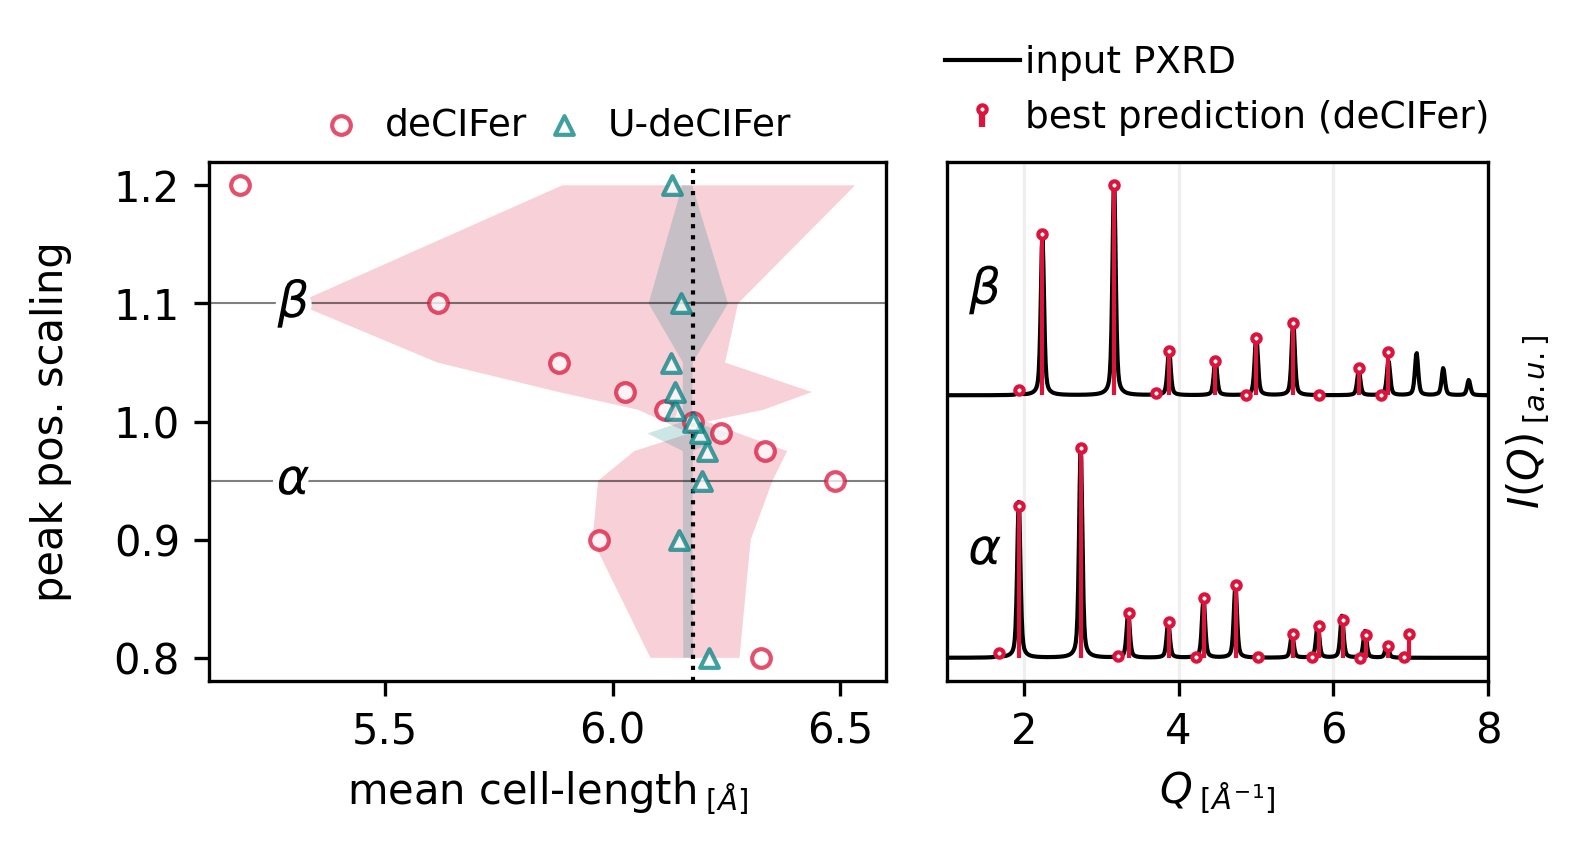

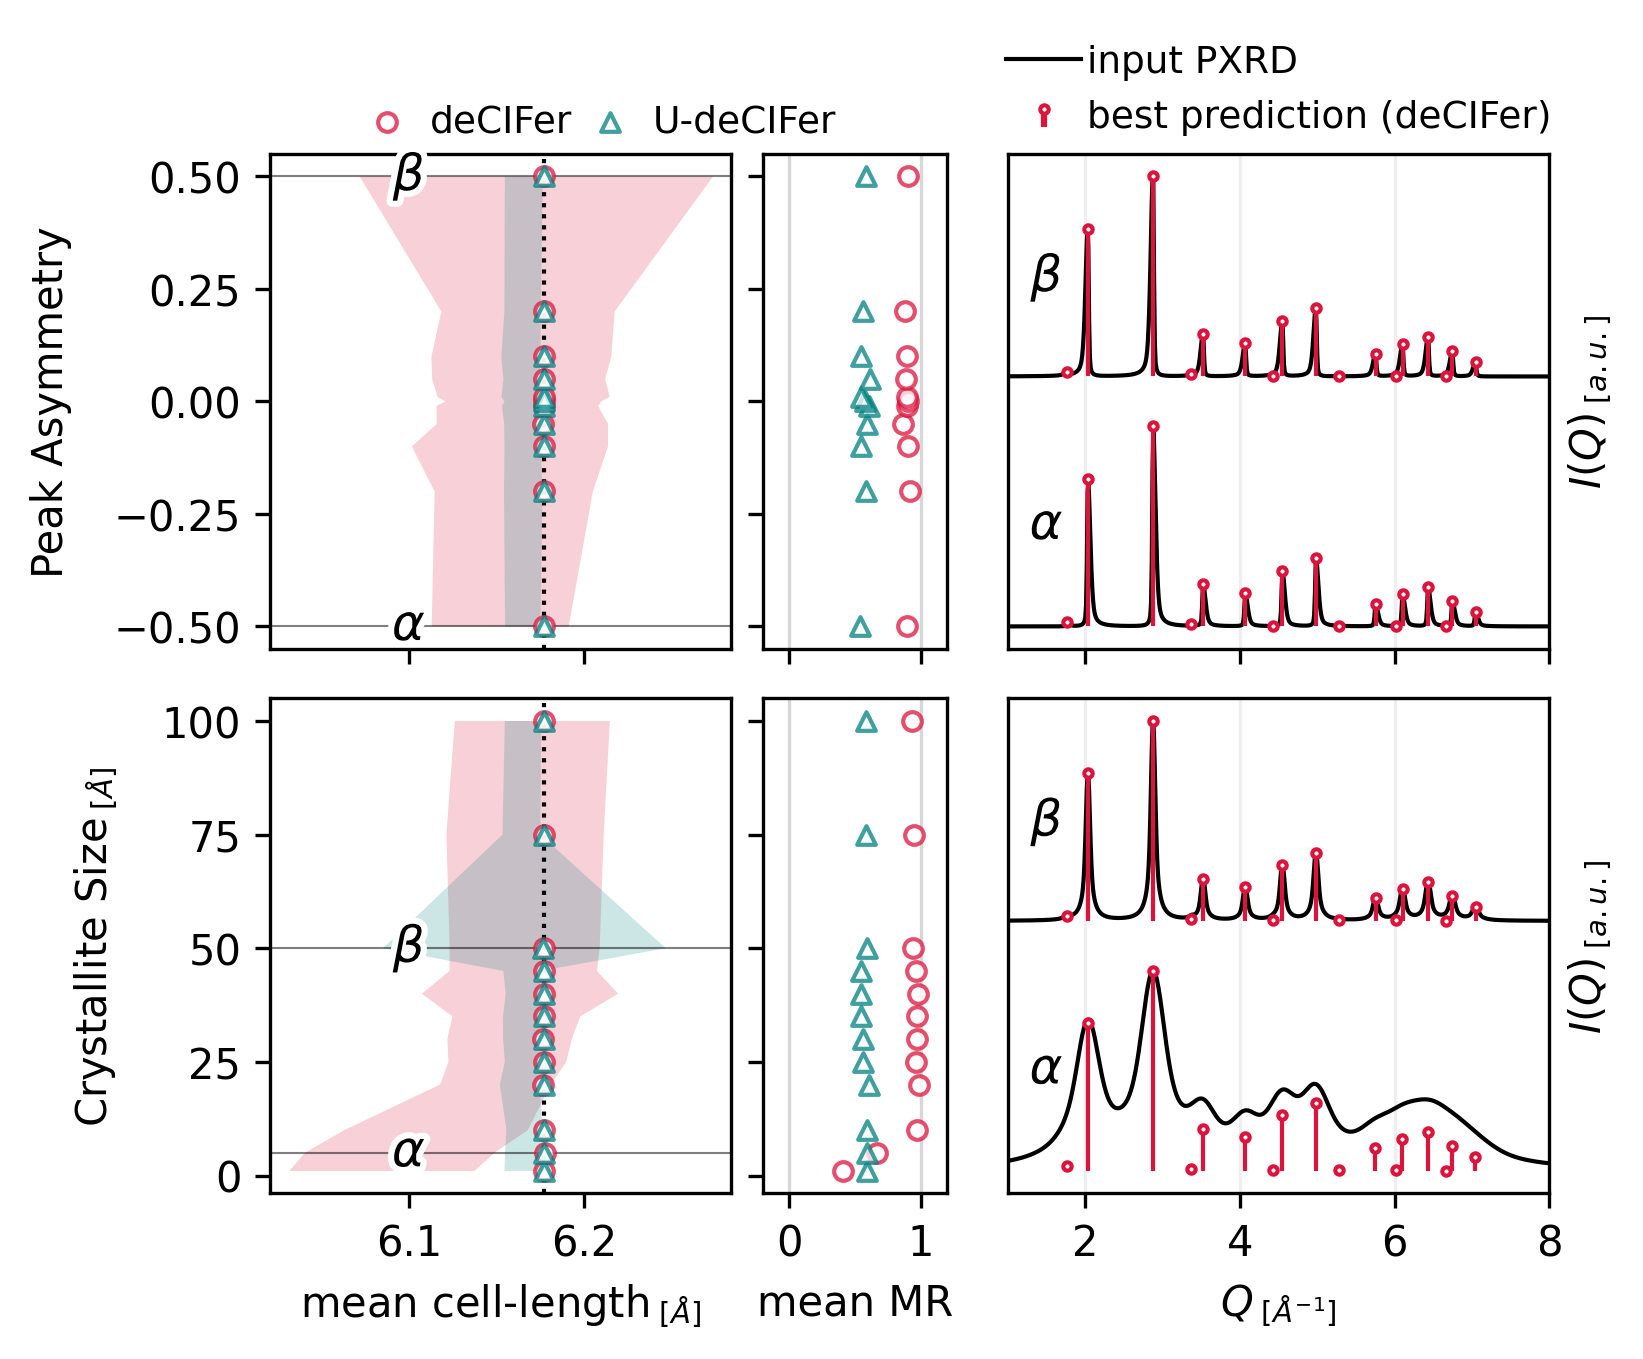

In [8]:
param_keys = [
    {
        "key": "q_scale", 
        "title": "peak pos. scaling", 
        "xlabel": "peak pos. scaling", 
        "unit": "", 
        "example_1_idx": 2, 
        "example_2_idx": 9,
        "example_none_idx": 5,
        "param_symbol_top": r"$\rhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\lhd\;\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_figure_structure_match_reversed(
    results_o,
    uresults_o,
    param_keys, 
    "ablation_peak_scaling.png", 
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None, #6.0,
    cell_max = None, #6.3,
    bbox_left=(0.5, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 5.3,
    AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left = None, #"best prediction",
    title_left_pad=17.0,
    show_mid = False
)

param_keys = [
    {
        "key": "peak_asymmetry", 
        "title": "Peak Asymmetry", 
        "xlabel": "Peak Asymmetry", 
        "unit": "", 
        "example_1_idx": 0, 
        "example_2_idx": 10,
        "example_none_idx": 5,
        "param_symbol_top": r"$/\!|$",
        "param_symbol_top_rot": 18.5,
        "param_symbol_bot": r"$|\!\backslash$",
        "param_symbol_bot_rot": -18.5,
        "param_symbol_size": 20
    },
        {
        "key": "particle_size", 
        "title": "Crystallite Size", 
        "xlabel": "Crystallite Size", 
        "unit": r"$_{\;[Å]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 9,
        "example_none_idx": 2,
        "param_symbol_top": r"o",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_figure_structure_match_reversed(
    results_o,
    uresults_o,
    param_keys, 
    "ablation_asym_size.png", 
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None, #6.0,
    cell_max = None, #6.3,
    bbox_left=(0.7, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 6.1,
    AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left = None, # "best prediction",
    title_left_pad=17.0,
    show_mid = True
)

KeyError: 'q_shift'

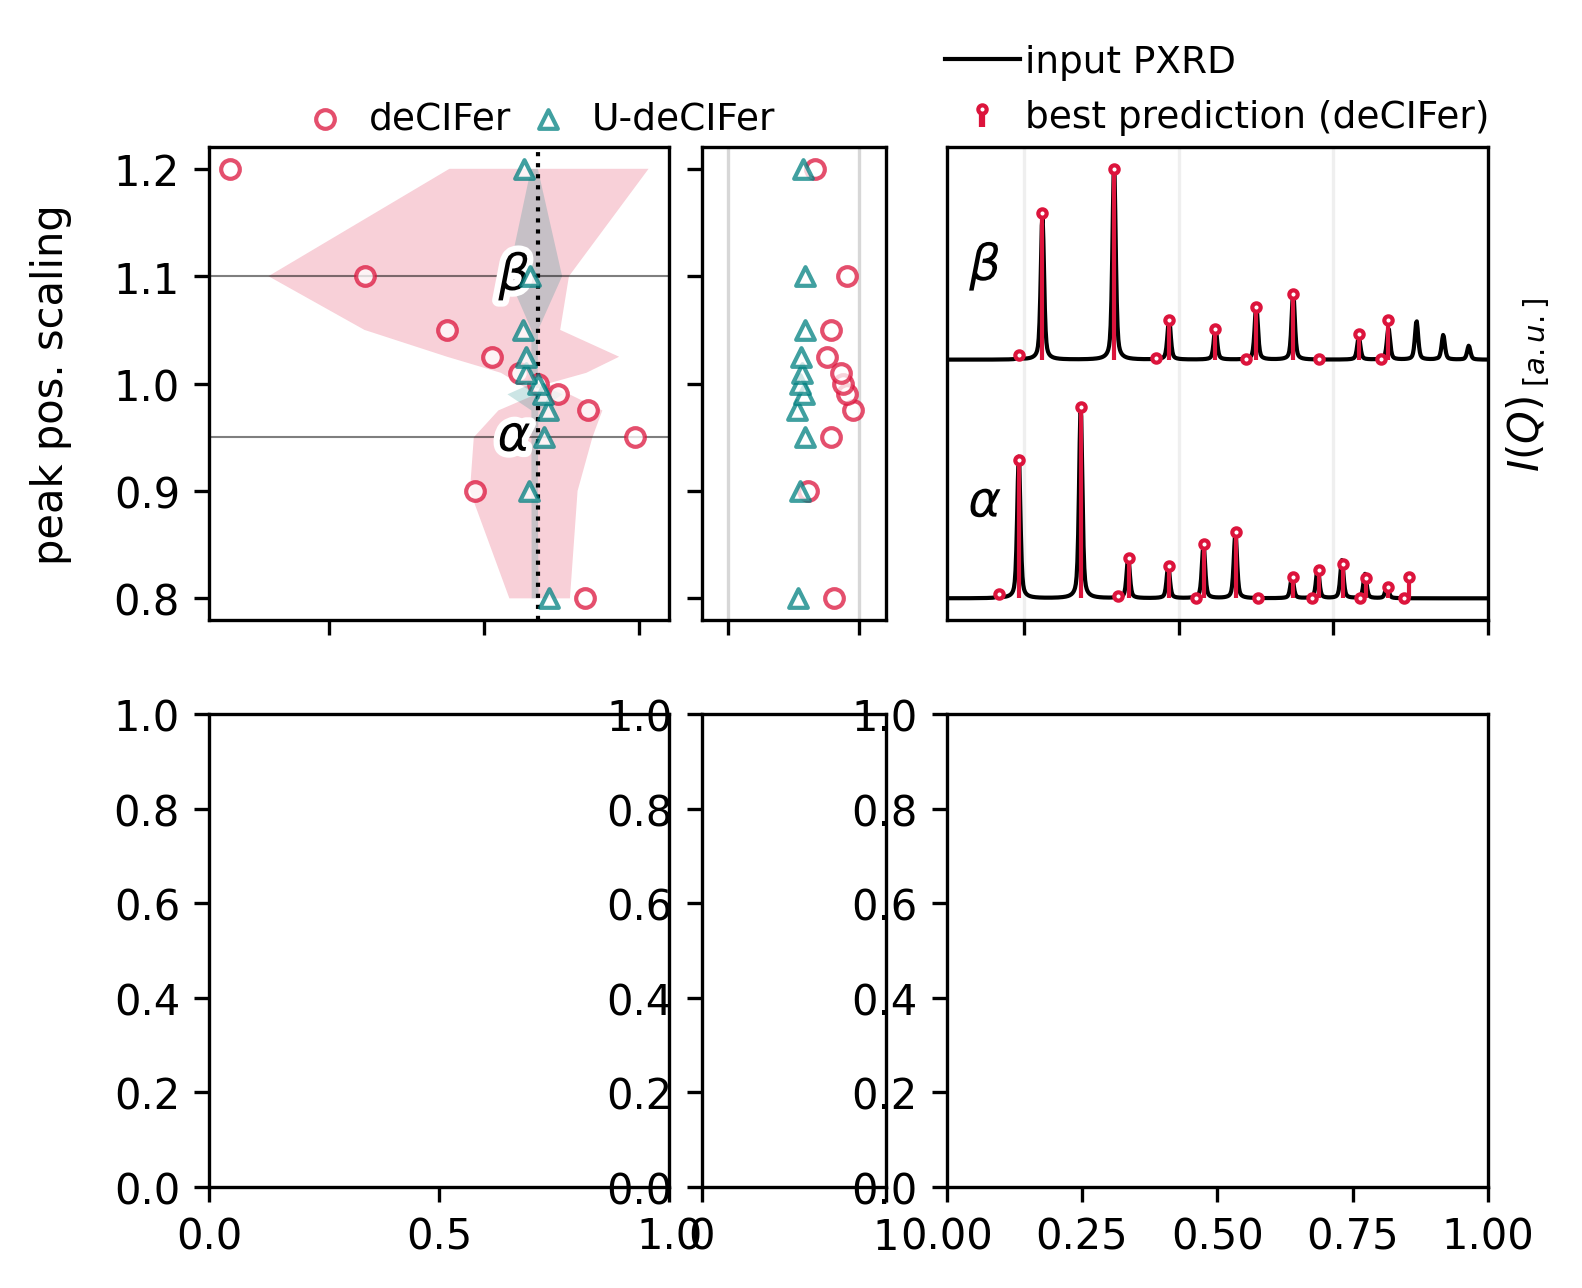

In [77]:
param_keys = [
    {
        "key": "q_scale", 
        "title": "peak pos. scaling", 
        "xlabel": "peak pos. scaling", 
        "unit": "", 
        "example_1_idx": 2, 
        "example_2_idx": 9,
        "example_none_idx": 5,
        "param_symbol_top": r"$\rhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\lhd\;\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "q_shift", 
        "title": "Peak Pos. Shift", 
        "xlabel": "Peak Pos. Shift", 
        "unit": r"$_{\;[Å^{-1}]}$", 
        "example_1_idx": 2,
        "example_2_idx": 8,
        "example_none_idx": 5,
        "param_symbol_top": r"$\lhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\rhd\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_figure_structure_match_reversed(
    results_o,
    uresults_o,
    param_keys, 
    "ablation_qs.pdf", 
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None, #6.0,
    cell_max = None, #6.3,
    bbox_left=(0.7, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 6.1,
    AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left = None, # "best prediction",
    title_left_pad=17.0,
    show_mid = True
)

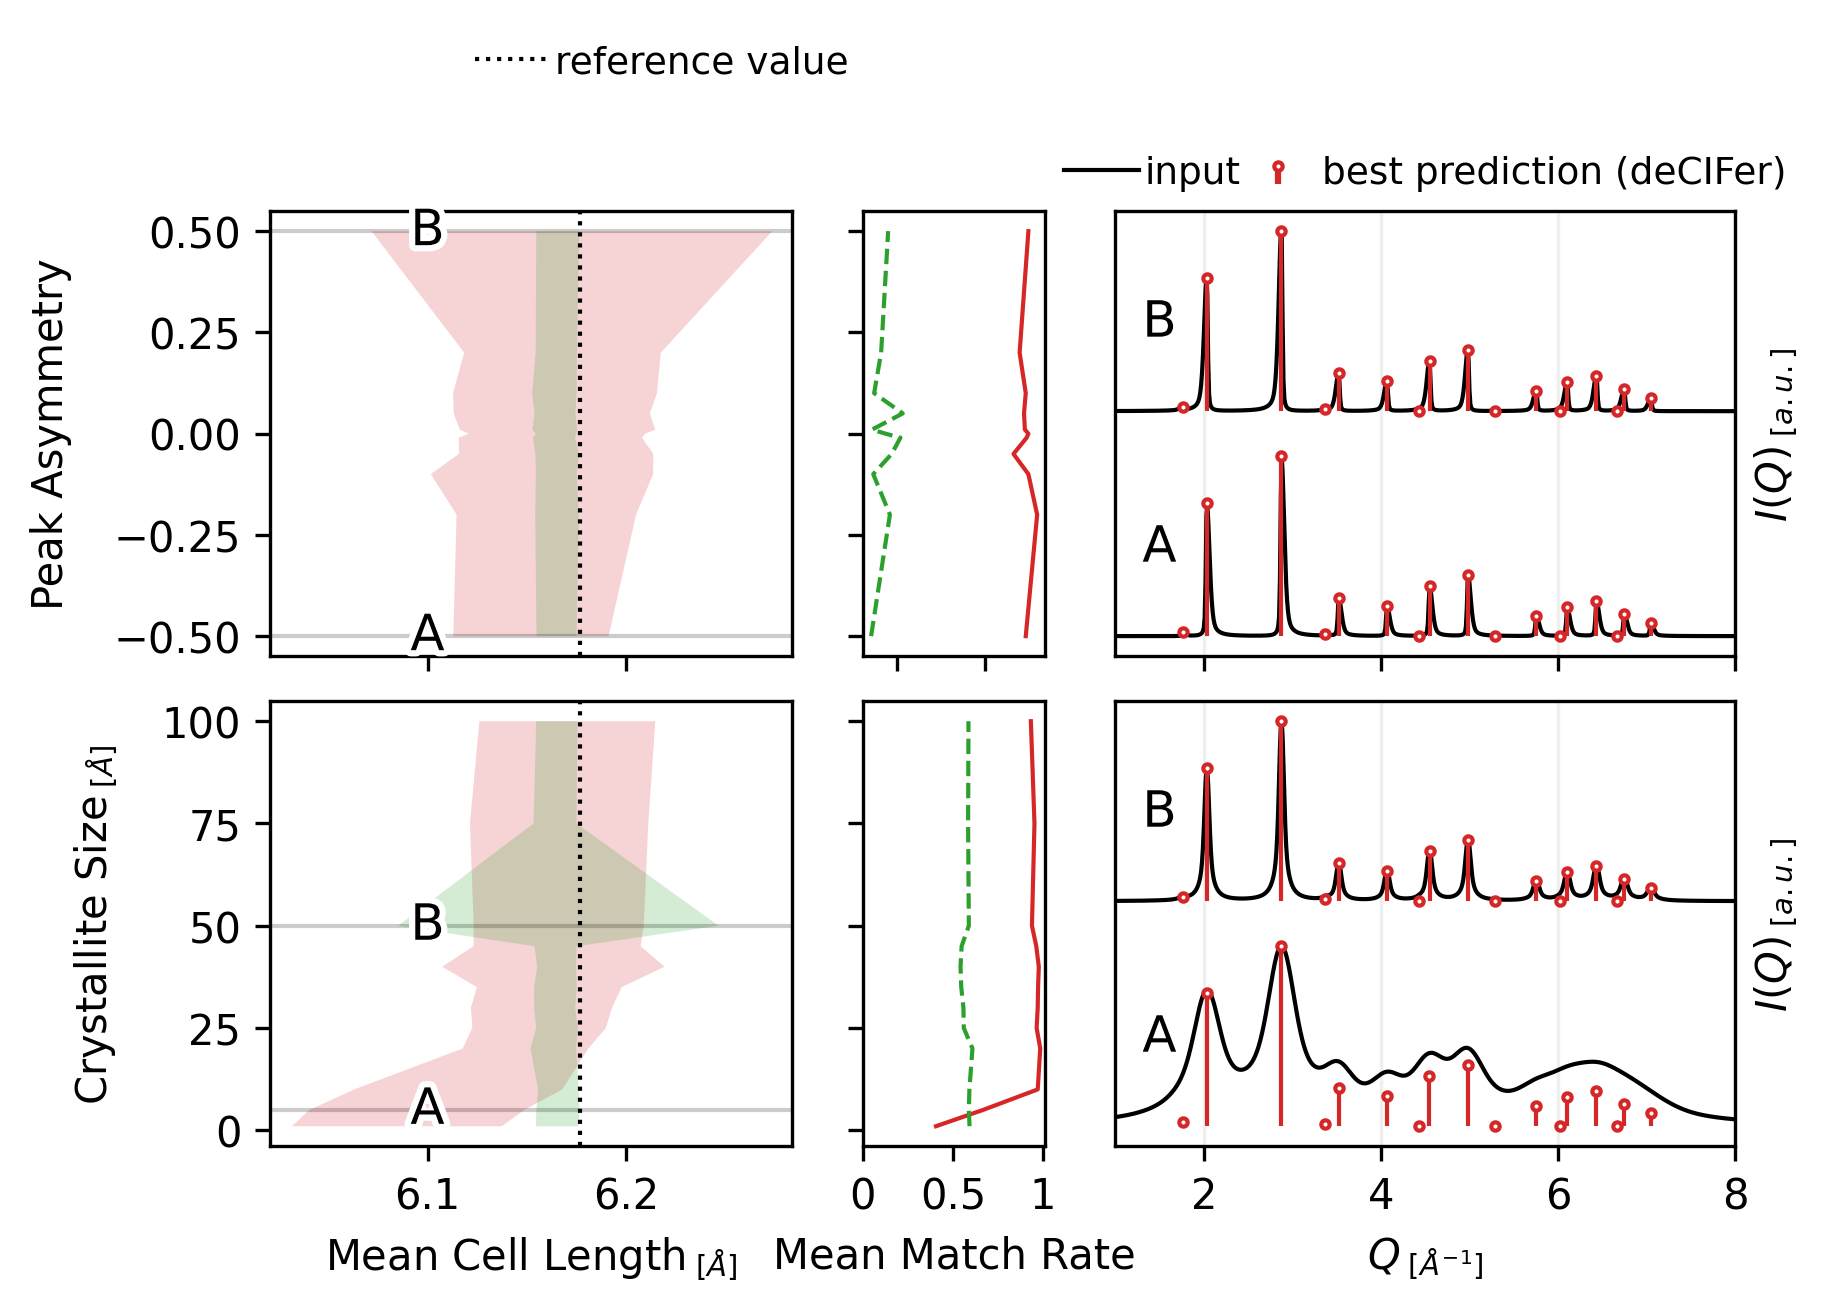

In [185]:
param_keys = [
    # {
    #     "key": "q_scale", 
    #     "title": "Peak Pos. Scaling", 
    #     "xlabel": "Peak Pos. Scaling", 
    #     "unit": "", 
    #     "example_1_idx": 2, 
    #     "example_2_idx": 9,
    #     "example_none_idx": 5,
    #     "param_symbol_top": r"$\rhd\lhd$",
    #     "param_symbol_top_rot": 0,
    #     "param_symbol_bot": r"$\lhd\;\rhd$",
    #     "param_symbol_bot_rot": 0,
    #     "param_symbol_size": 12
    # },
    {
        "key": "peak_asymmetry", 
        "title": "Peak Asymmetry", 
        "xlabel": "Peak Asymmetry", 
        "unit": "", 
        "example_1_idx": 0, 
        "example_2_idx": 10,
        "example_none_idx": 5,
        "param_symbol_top": r"$/\!|$",
        "param_symbol_top_rot": 18.5,
        "param_symbol_bot": r"$|\!\backslash$",
        "param_symbol_bot_rot": -18.5,
        "param_symbol_size": 20
    },
        {
        "key": "particle_size", 
        "title": "Crystallite Size", 
        "xlabel": "Crystallite Size", 
        "unit": r"$_{\;[Å]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 9,
        "example_none_idx": 2,
        "param_symbol_top": r"o",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_figure_structure_match_reversed(
    results_o,
    uresults_o,
    param_keys, 
    "ablation_structure_match_reversed.pdf", 
    dpi=300, 
    figscale=0.9, 
    figlen=7, 
    fig_height_factor=2.25,
    cell_min = None, #6.0,
    cell_max = None, #6.3,
    bbox_left=(0.75, 1.45),
    AB_x = 6.1,
    cell_tags = ["a", "b", "c"],
    show_mean = False,
    show_best = False,
)

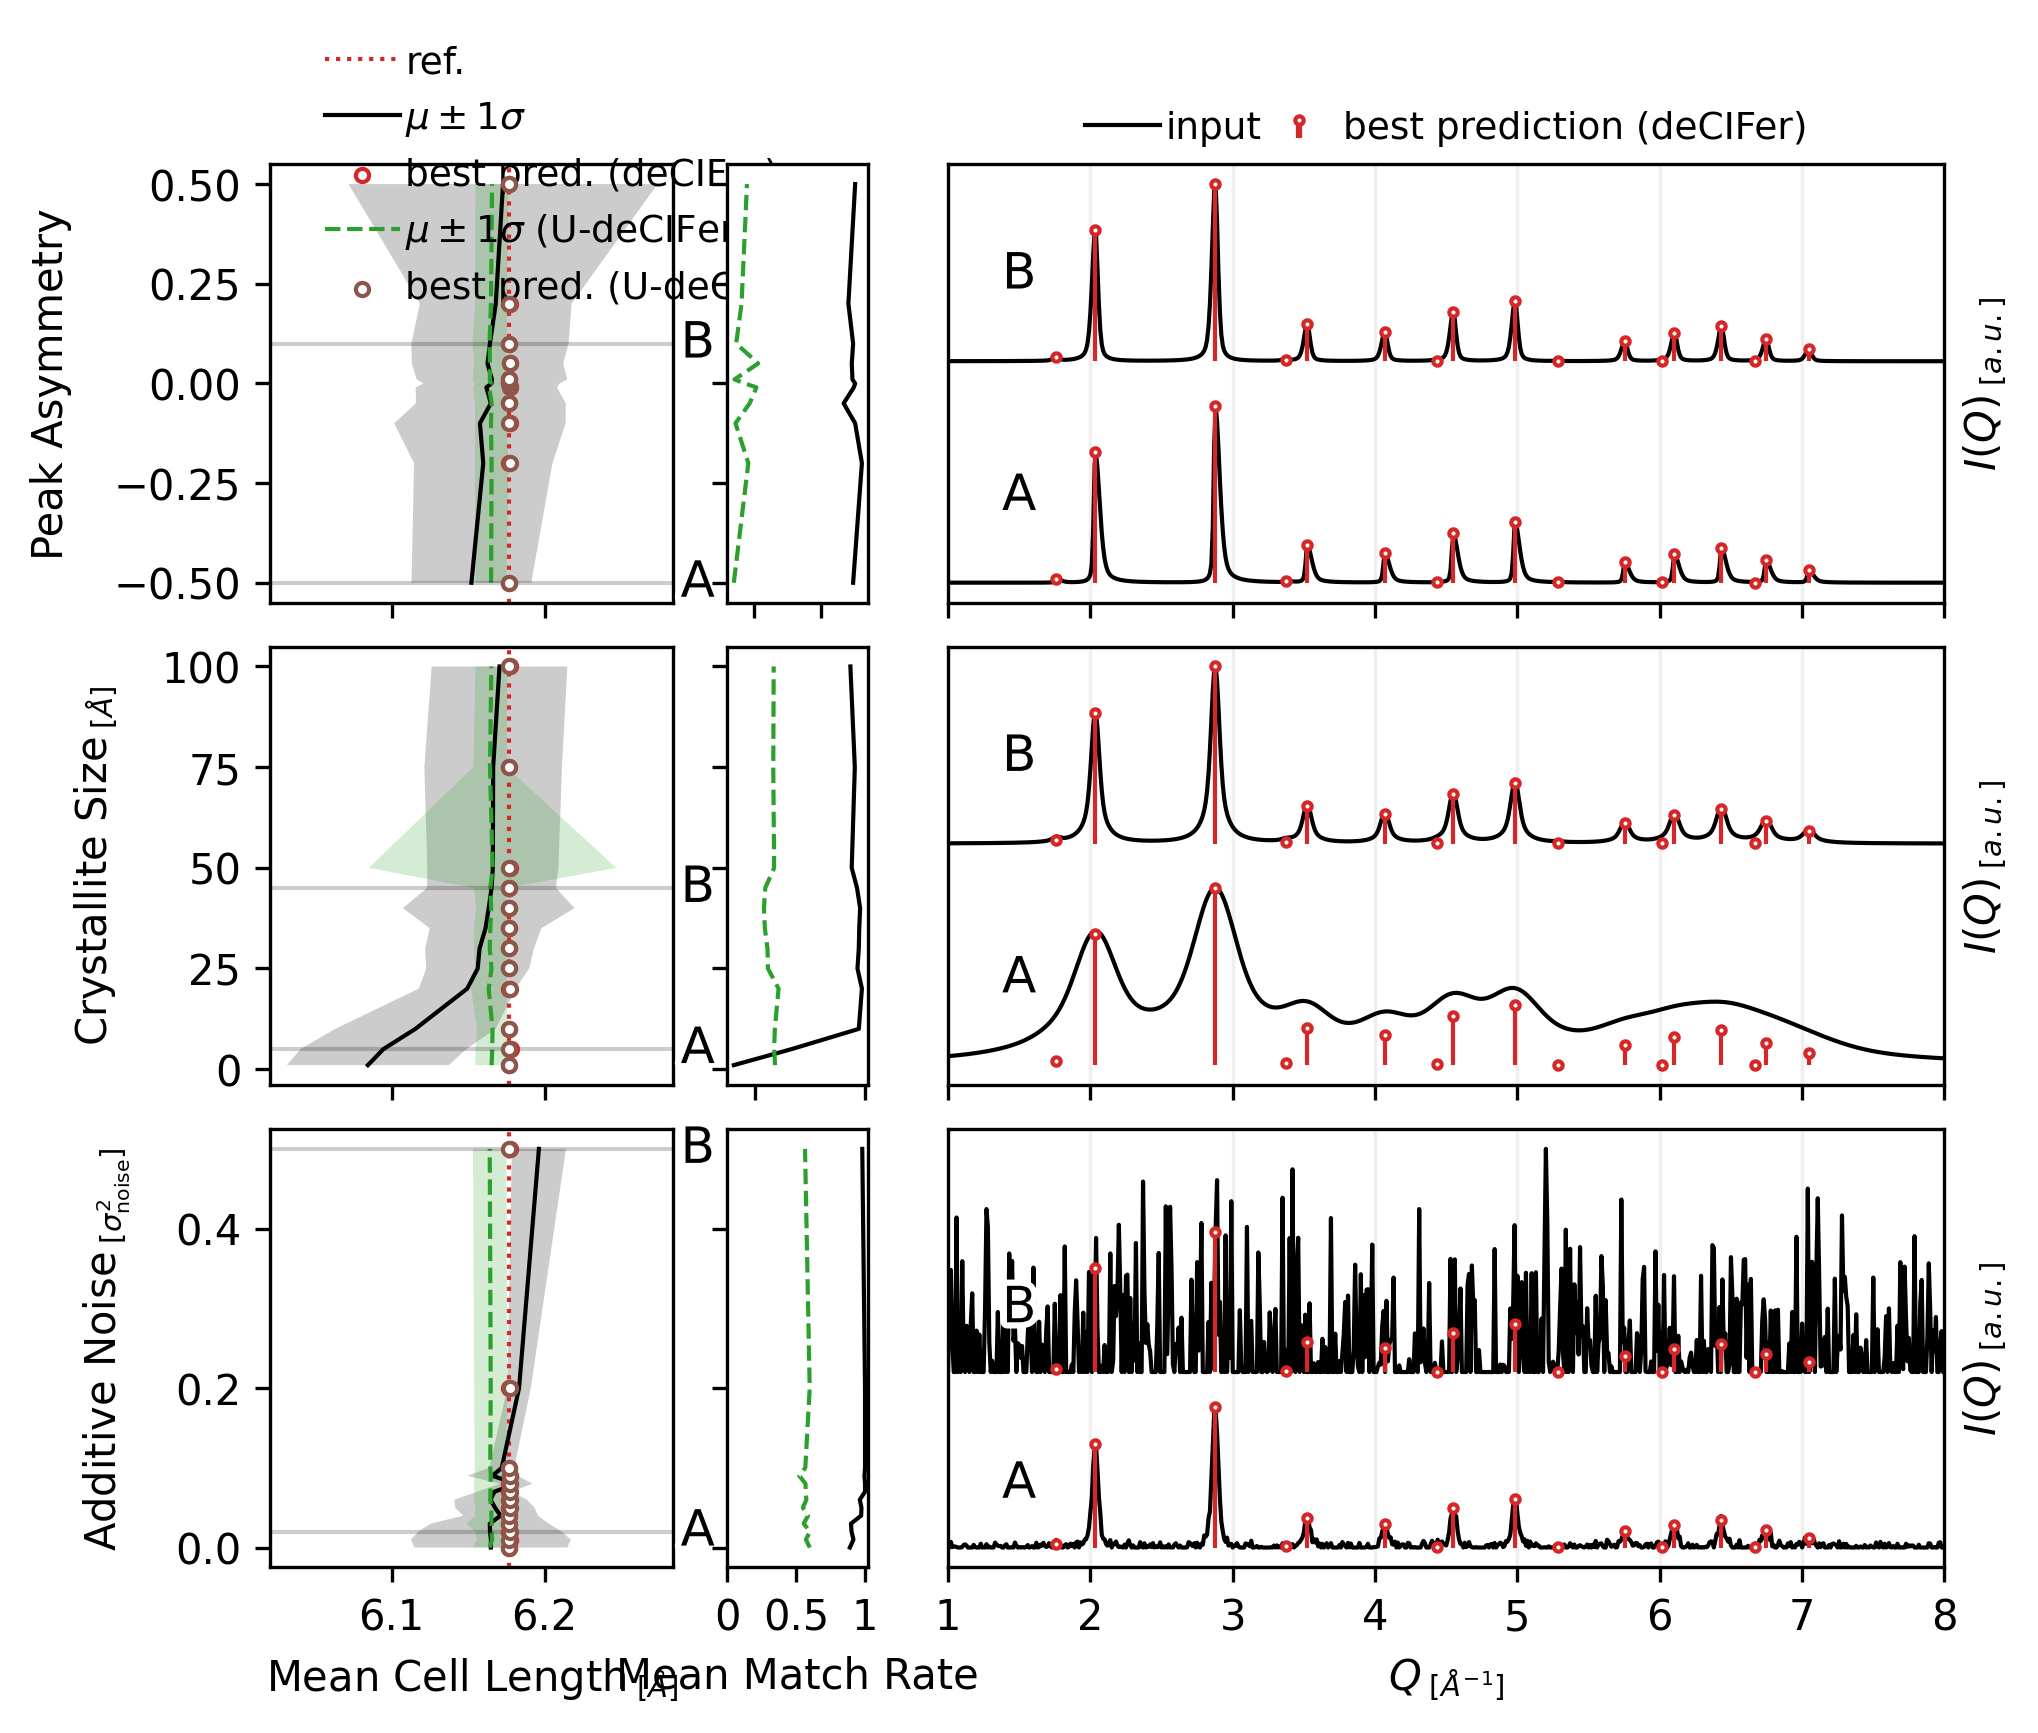

In [121]:
param_keys = [
    {
        "key": "peak_asymmetry", 
        "title": "Peak Asymmetry", 
        "xlabel": "Peak Asymmetry", 
        "unit": "", 
        "example_1_idx": 0, 
        "example_2_idx": 8,
        "example_none_idx": 5,
        "param_symbol_top": r"$/\!|$",
        "param_symbol_top_rot": 18.5,
        "param_symbol_bot": r"$|\!\backslash$",
        "param_symbol_bot_rot": -18.5,
        "param_symbol_size": 20
    },
        {
        "key": "particle_size", 
        "title": "Crystallite Size", 
        "xlabel": "Crystallite Size", 
        "unit": r"$_{\;[Å]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 8,
        "example_none_idx": 2,
        "param_symbol_top": r"o",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "noise", 
        "title": "Gaussian Noise", 
        "xlabel": "Additive Noise", 
        "unit": r"$_{\;[\sigma_{\mathrm{noise}}^2]}$", 
        "example_1_idx": 2, 
        "example_2_idx": 12,
        "example_none_idx": 5,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_figure_structure_match_reversed(
    results_o,
    uresults_o,
    param_keys, 
    "ablation_structure_match_reversed.pdf", 
    dpi=300, 
    figscale=0.9, 
    figlen=8, 
    fig_height_factor=2.25,
    cell_min = None, #6.0,
    cell_max = None, #6.3,
    bbox_left=(0.75, 1.35),
    AB_x = 6.3,
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
)

In [170]:
def ablation_figure_structure_match(param_keys, savepath=None):
    # Colors
    c_ex1 = "k"
    c_ex2 = "k"
    c_pred1 = "C3"#"grey"
    c_pred2 = "C3"#"grey"
    c_trend = "k"#"C3"
    c_min = "C3"
    c_ref = "C3"
    
    # Other
    pred_marker_size = 2
    fig_height_factor = 2.25
    
    n_params = len(param_keys)
    
    # Create the figure with your desired size.
    fig = plt.figure(figsize=(10, fig_height_factor * n_params))
    
    # Outer GridSpec: Divide the figure into 2 main groups.
    # Group 1: Column 0 (placed on the left)
    # Group 2: Columns 1 and 2 (placed on the right)
    # outer.wspace controls the gap between these two groups.
    outer = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
    
    # Left group for column 0 (a single column per row)
    gs_left = gridspec.GridSpecFromSubplotSpec(n_params, 1, subplot_spec=outer[0])
    
    # Right group for columns 1 and 2, with a small gap between them.
    gs_right = gridspec.GridSpecFromSubplotSpec(n_params, 2, subplot_spec=outer[1], width_ratios=[0.3, 1], wspace=0.05)
    
    # Create an array to hold your axes in a structure similar to before.
    axes = np.empty((n_params, 3), dtype=object)
    for i in range(n_params):
        axes[i, 0] = fig.add_subplot(gs_left[i, 0])  # column 0 (left group)
        axes[i, 1] = fig.add_subplot(gs_right[i, 0])  # column 1 (right group)
        axes[i, 2] = fig.add_subplot(gs_right[i, 1])  # column 2 (right group)
    
    for i, param in enumerate(param_keys):
        param_key = param["key"]
        param_key_title = param["title"]
        param_key_xlabel = param["xlabel"]
        param_key_unit = param["unit"]
        param_symbol_top = param["param_symbol_top"]
        param_symbol_top_rot = param["param_symbol_top_rot"]
        param_symbol_bot = param["param_symbol_bot"]
        param_symbol_bot_rot = param["param_symbol_bot_rot"]
        param_symbol_size = param["param_symbol_size"]
    
        param_val_keys = list(results[param_key].keys())
        example_1_idx = param["example_1_idx"]
        example_2_idx = param["example_2_idx"]
        example_1_key = param_val_keys[example_1_idx]
        example_2_key = param_val_keys[example_2_idx]
    
        example_none_idx = param["example_none_idx"]
        example_none_key = param_val_keys[example_none_idx]
        
        # --- Top subplot: main plot for current parameter.
        ax = axes[i, 0]
        # Extract data for example 1 (A)
        q_A = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
        iq_A = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
        q_A_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq_A_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
        
        # Extract data for example 2 (B)
        q_B = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
        iq_B = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
        q_B_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq_B_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
        # Extract data for example 'none' (X)
        q_X = results[param_key][example_none_key]["best_experiment"]["pxrd_ref"]["q"]
        iq_X = results[param_key][example_none_key]["best_experiment"]["pxrd_ref"]["iq"]
        q_X_disc = results[param_key][example_none_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq_X_disc = results[param_key][example_none_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
        
        peak_scaling = 0.8
        ax.plot(q_B, iq_B * peak_scaling, lw=1, c=c_ex2)
        ax.plot(q_A, iq_A * peak_scaling - 1, lw=1, c=c_ex1, label='input')
        
        stem = ax.stem(q_A_disc,  iq_A_disc / 100 * peak_scaling - 1, linefmt=f'{c_pred1}-', markerfmt=f'{c_pred1}o', basefmt=' ', label='best prediction', bottom=-1)  # 'k' for black color
        stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=0.5)
        stem.stemlines.set(lw=1.0)
        stem = ax.stem(q_B_disc, iq_B_disc / 100 * peak_scaling, linefmt=f'{c_pred2}-', markerfmt=f'{c_pred1}o', basefmt=' ')  # 'k' for black color
        stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=0.5)
        stem.stemlines.set(lw=1.0)
        
        ax.text(1.5, -0.5, "A", ha='center', va='top', fontsize=12, color='black',
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        ax.text(1.5, 0.5, "B", ha='center', va='top', fontsize=12, color='black',
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
        ax.grid(alpha=0.2)
        ax.set(
            yticks=[],
            ylabel=r"$I(Q)_{\;[a.u.]}$",
            xlim=(1, 8),
        )
        if i == 0:
            ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2,
                    frameon=False, columnspacing=0.0, handletextpad=0.15)
            ax.set_xticklabels([])
        elif i == len(param_keys) -1:  
            ax.set_xlabel(r"$Q_{\;[Å^{-1}]}$")
        else:
            ax.set_xticklabels([])
    
        # --- #
        best_cifs = [results[param_key][key]["best_experiment"]["generated_cif"] for key in param_val_keys]
        best_lengths = [np.mean([extract_numeric_property(cif, f"_cell_length_{x}") for x in ["a", "b", "c"]]) for cif in best_cifs]
        best_angles = [np.mean([extract_numeric_property(cif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]]) for cif in best_cifs]
    
        n_samples = len(results[param_key][param_val_keys[0]]["experiments"])
        all_lengths = []
        all_angles = []
        for key in param_val_keys:
            experiments = results[param_key][key]["experiments"]
            lengths, angles = [], []
            for experiment in experiments:
                cif = experiment["generated_cif"]
                lengths.extend([extract_numeric_property(cif, f"_cell_length_{x}") for x in ["a", "b", "c"]])
                angles.extend([extract_numeric_property(cif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]])
            all_lengths.append(lengths)
            all_angles.append(angles)
    
        mean_lengths = np.array([np.mean(l) for l in all_lengths])
        std_lengths = np.array([np.std(l) for l in all_lengths])
    
        mean_angles = np.array([np.mean(l) for l in all_angles])
        std_angles = np.array([np.std(l) for l in all_angles])
    
        ax = axes[i, 2]
                
        # Compute reference means for each structure using the best experiment's generated structure.
        ref_structure = results[param_key][example_1_key]["best_experiment"]["reference_structure"]
        ref_cell = np.array(ref_structure.lattice.abc)
        ref_mean = ref_cell.mean()
        
        # Draw dotted vertical lines for the reference means.
        hline = ax.axvline(ref_mean, color='k', linestyle=':', linewidth=1, c=c_ref, label='reference value')
        
        ax.plot(mean_lengths, param_val_keys, label=r"$\mu \pm 1\sigma$", color=c_trend, lw=1.0)
        ax.scatter(best_lengths, param_val_keys, label="$\mathrm{min}\;R_{\mathrm{wp}}$", color=c_min, s=10, fc='white', zorder=10)
        ax.fill_betweenx(param_val_keys, mean_lengths - std_lengths, mean_lengths + std_lengths, color=c_trend, alpha=0.2, ec='none')
        
        ax.axhline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5) 
        ax.axhline(example_2_idx, c='k', lw=1,ls='--', alpha=0.5) 
        ax.grid(alpha=0.2, which='major')
    
        letter_pos = 5.9
        ax.text(letter_pos, example_1_key, "A", ha='center', va='center', fontsize=12, color='black',
                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        ax.text(letter_pos, example_2_key, "B", ha='center', va='center', fontsize=12, color='black',
                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        
        ax.set_ylabel(f'{param_key_xlabel}{param_key_unit}', labelpad=10.0)
        ax.set_yticks(list(param_val_keys))
        ax.set_yticklabels([str(k) for k in param_val_keys])
    
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        if i == 0:
            ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3,
                    frameon=False, columnspacing=0.0, handletextpad=0.15)
            ax.set_xticklabels([])
            # ax.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
        elif i == len(param_keys) -1:
            ax.set_xlabel(r"Mean Cell Length$_{\;[Å]}$")
        else:
            ax.set_xticklabels([])

        # <<<< #
        ax = axes[i, 1]
        struc_match_rate = []
        for key in param_val_keys:
            experiments = results[param_key][key]["experiments"]
            mr = []
            for experiment in experiments:
                mr.append(experiment["structure_match"] * 100)
            struc_match_rate.append(mr)

        mean_struc_match_rate = np.array([np.mean(l) for l in struc_match_rate])
        std_struc_match_rate = np.array([np.std(l) for l in struc_match_rate])

        ax.plot(mean_struc_match_rate, param_val_keys, label=r"$\mu \pm 1\sigma$", color=c_trend, lw=1.0)
        minmr = np.clip(mean_struc_match_rate - std_struc_match_rate, 0, 100)
        maxmr = np.clip(mean_struc_match_rate + std_struc_match_rate, 0, 100)
        ax.fill_betweenx(param_val_keys, minmr, maxmr, color=c_trend, alpha=0.2, ec='none')
        if i == len(param_keys)-1:
            ax.set_xlabel(r"Match Rate$_{\;[\%]}$")
        else:
            ax.set_xticklabels([])
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.set_yticklabels([])
    
    # Adjust the axes[i,0]
    # Determine global y-limits across all axes in column 0.
    xlim_min = 5.8 #min(ax.get_ylim()[0] for ax in axes[:, 0])
    xlim_max = 6.4 #max(ax.get_ylim()[1] for ax in axes[:, 0])
    
    # Set the same y-limits for all axes in column 1.
    for ax in axes[:, 2]:
        ax.set_xlim(xlim_min, xlim_max)
    
    plt.subplots_adjust(hspace=0.1)
    
    plt.show()

    if savepath is not None:
        fig.savefig(savepath, bbox_inches='tight')

NameError: name 'results' is not defined

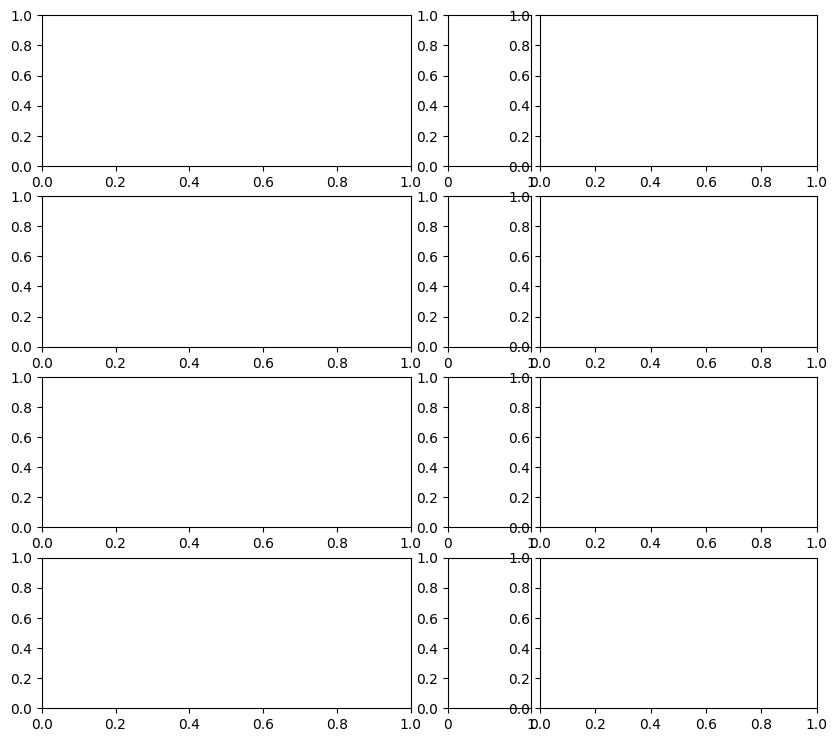

In [171]:
param_keys = [
    {
        "key": "q_shift", 
        "title": "Peak Pos. Shift", 
        "xlabel": "Peak Pos. Shift", 
        "unit": r"$_{\;[Å^{-1}]}$", 
        "example_1_idx": 2,
        "example_2_idx": 8,
        "example_none_idx": 5,
        "param_symbol_top": r"$\lhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\rhd\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    # {
    #     "key": "q_scale", 
    #     "title": "Peak Pos. Scaling", 
    #     "xlabel": "Peak Pos. Scale Factor", 
    #     "unit": "", 
    #     "example_1_idx": 3, 
    #     "example_2_idx": 7,
    #     "example_none_idx": 5,
    #     "param_symbol_top": r"$\rhd\lhd$",
    #     "param_symbol_top_rot": 0,
    #     "param_symbol_bot": r"$\lhd\;\rhd$",
    #     "param_symbol_bot_rot": 0,
    #     "param_symbol_size": 12
    # },
    {
        "key": "peak_asymmetry", 
        "title": "Peak Asymmetry", 
        "xlabel": "Peak Asymmetry Factor", 
        "unit": "", 
        "example_1_idx": 0, 
        "example_2_idx": 10,
        "example_none_idx": 5,
        "param_symbol_top": r"$/\!|$",
        "param_symbol_top_rot": 18.5,
        "param_symbol_bot": r"$|\!\backslash$",
        "param_symbol_bot_rot": -18.5,
        "param_symbol_size": 20
    },
        {
        "key": "particle_size", 
        "title": "Crystallite Size", 
        "xlabel": "Crystallite Size", 
        "unit": r"$_{\;[Å]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 8,
        "example_none_idx": 2,
        "param_symbol_top": r"o",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "noise", 
        "title": "Gaussian Noise", 
        "xlabel": "Additive Noise", 
        "unit": r"$_{\;[\sigma_{\mathrm{noise}}^2]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 10,
        "example_none_idx": 5,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    # {
    #     "key": "base_fwhm", 
    #     "title": "Instrumental Broadening", 
    #     "xlabel": "FWHM", 
    #     "unit": "", 
    #     "example_1_idx": 2, 
    #     "example_2_idx": 10,
    #     "example_none_idx": 5,
    #     "param_symbol_top": r"",
    #     "param_symbol_top_rot": 0,
    #     "param_symbol_bot": r"",
    #     "param_symbol_bot_rot": 0,
    #     "param_symbol_size": 12
    # },
]

ablation_figure_structure_match(param_keys, "ablation_structure_match.png")

In [330]:
def ablation_figure_compact(param_keys, savepath=None):
    # Colors
    c_ex1 = "k"
    c_ex2 = "k"
    c_pred1 = "C3"#"grey"
    c_pred2 = "C3"#"grey"
    c_trend = "k"#"C3"
    c_min = "C3"
    c_ref = "C3"
    
    # Other
    pred_marker_size = 2
    fig_height_factor = 2.25
    
    n_params = len(param_keys)
    
    # Create the figure with your desired size.
    fig = plt.figure(figsize=(6, fig_height_factor * n_params), dpi=200)
    
    # Outer GridSpec: Divide the figure into 2 groups.
    # We swap the order such that:
    # - New left: length predictions (originally column 1, from the right group)
    # - New right: main plot (originally column 0, from the left group)
    # Adjust width ratios accordingly.
    outer = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
    
    # New left group for length predictions (single column per row)
    gs_length = gridspec.GridSpecFromSubplotSpec(n_params, 1, subplot_spec=outer[0])
    
    # New right group for the main plot (single column per row)
    gs_main = gridspec.GridSpecFromSubplotSpec(n_params, 1, subplot_spec=outer[1])
    
    # Create an array to hold your axes in the new order.
    axes = np.empty((n_params, 2), dtype=object)
    for i in range(n_params):
        axes[i, 0] = fig.add_subplot(gs_length[i, 0])  # New column 0: length predictions
        axes[i, 1] = fig.add_subplot(gs_main[i, 0])      # New column 1: main plot
    
    for i, param in enumerate(param_keys):
        param_key = param["key"]
        param_key_title = param["title"]
        param_key_xlabel = param["xlabel"]
        param_key_unit = param["unit"]
        param_symbol_top = param["param_symbol_top"]
        param_symbol_top_rot = param["param_symbol_top_rot"]
        param_symbol_bot = param["param_symbol_bot"]
        param_symbol_bot_rot = param["param_symbol_bot_rot"]
        param_symbol_size = param["param_symbol_size"]
    
        param_val_keys = list(results[param_key].keys())
        example_1_idx = param["example_1_idx"]
        example_2_idx = param["example_2_idx"]
        example_1_key = param_val_keys[example_1_idx]
        example_2_key = param_val_keys[example_2_idx]
    
        example_none_idx = param["example_none_idx"]
        example_none_key = param_val_keys[example_none_idx]
        
        # --- Top subplot: main plot for current parameter.
        ax = axes[i, 0]
        # Extract data for example 1 (A)
        q_A = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
        iq_A = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
        q_A_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq_A_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
        
        # Extract data for example 2 (B)
        q_B = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
        iq_B = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
        q_B_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq_B_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
        # Extract data for example 'none' (X)
        q_X = results[param_key][example_none_key]["best_experiment"]["pxrd_ref"]["q"]
        iq_X = results[param_key][example_none_key]["best_experiment"]["pxrd_ref"]["iq"]
        q_X_disc = results[param_key][example_none_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq_X_disc = results[param_key][example_none_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
        
        peak_scaling = 0.8
        ax.plot(q_B, iq_B * peak_scaling, lw=1, c=c_ex2)
        ax.plot(q_A, iq_A * peak_scaling - 1, lw=1, c=c_ex1, label='input')
        
        stem = ax.stem(q_A_disc,  iq_A_disc / 100 * peak_scaling - 1, linefmt=f'{c_pred1}-', markerfmt=f'{c_pred1}o', basefmt=' ', label='best prediction', bottom=-1)  # 'k' for black color
        stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=0.5)
        stem.stemlines.set(lw=1.0)
        stem = ax.stem(q_B_disc, iq_B_disc / 100 * peak_scaling, linefmt=f'{c_pred2}-', markerfmt=f'{c_pred1}o', basefmt=' ')  # 'k' for black color
        stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=0.5)
        stem.stemlines.set(lw=1.0)
        
        ax.text(1.5, -0.5, "A", ha='center', va='top', fontsize=12, color='black',
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        ax.text(1.5, 0.5, "B", ha='center', va='top', fontsize=12, color='black',
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
        ax.grid(alpha=0.2)
        ax.set(
            yticks=[],
            ylabel=r"$I(Q)_{\;[a.u.]}$",
            xlim=(1, 8),
        )
        if i == 0:
            ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2,
                    frameon=False, columnspacing=0.0, handletextpad=0.15)
            ax.set_xticklabels([])
        elif i == len(param_keys) -1:  
            ax.set_xlabel(r"$Q_{\;[Å^{-1}]}$")
        else:
            ax.set_xticklabels([])
    
        # --- #
        best_cifs = [results[param_key][key]["best_experiment"]["generated_cif"] for key in param_val_keys]
        best_lengths = [np.mean([extract_numeric_property(cif, f"_cell_length_{x}") for x in ["a", "b", "c"]]) for cif in best_cifs]
        best_angles = [np.mean([extract_numeric_property(cif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]]) for cif in best_cifs]
    
        n_samples = len(results[param_key][param_val_keys[0]]["experiments"])
        all_lengths = []
        all_angles = []
        for key in param_val_keys:
            experiments = results[param_key][key]["experiments"]
            lengths, angles = [], []
            for experiment in experiments:
                cif = experiment["generated_cif"]
                lengths.extend([extract_numeric_property(cif, f"_cell_length_{x}") for x in ["a", "b", "c"]])
                angles.extend([extract_numeric_property(cif, f"_cell_angle_{x}") for x in ["alpha", "beta", "gamma"]])
            all_lengths.append(lengths)
            all_angles.append(angles)
    
        mean_lengths = np.array([np.mean(l) for l in all_lengths])
        std_lengths = np.array([np.std(l) for l in all_lengths])
    
        mean_angles = np.array([np.mean(l) for l in all_angles])
        std_angles = np.array([np.std(l) for l in all_angles])
    
        ax = axes[i, 1]
                
        # Compute reference means for each structure using the best experiment's generated structure.
        ref_structure = results[param_key][example_1_key]["best_experiment"]["reference_structure"]
        ref_cell = np.array(ref_structure.lattice.abc)
        ref_mean = ref_cell.mean()
        
        # Draw dotted vertical lines for the reference means.
        hline = ax.axvline(ref_mean, color='k', linestyle=':', linewidth=1, c=c_ref, label='ref.')
        
        ax.plot(mean_lengths, param_val_keys, label=r"$\mu \pm 1\sigma$", color=c_trend, lw=1.0)
        ax.scatter(best_lengths, param_val_keys, label="$\mathrm{min}\;R_{\mathrm{wp}}$", color=c_min, s=10, fc='white', zorder=10)
        ax.fill_betweenx(param_val_keys, mean_lengths - std_lengths, mean_lengths + std_lengths, color=c_trend, alpha=0.2, ec='none')
        
        ax.axhline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5) 
        ax.axhline(example_2_idx, c='k', lw=1,ls='--', alpha=0.5) 
        ax.grid(alpha=0.2, which='major')
    
        letter_pos = 5.9
        ax.text(letter_pos, example_1_key, "A", ha='center', va='center', fontsize=12, color='black',
                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        ax.text(letter_pos, example_2_key, "B", ha='center', va='center', fontsize=12, color='black',
                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        
        ax.set_ylabel(f'{param_key_xlabel}{param_key_unit}', labelpad=10.0)
        ax.set_yticks(list(param_val_keys))
        ax.set_yticklabels([str(k) for k in param_val_keys])
    
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        if i == 0:
            ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3,
                    frameon=False, columnspacing=0.0, handletextpad=0.15)
            ax.set_xticklabels([])
            # ax.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
        elif i == len(param_keys) -1:
            ax.set_xlabel(r"Mean Cell Length$_{\;[Å]}$")
        else:
            ax.set_xticklabels([])
    
    # Adjust the axes[i,0]
    # Determine global y-limits across all axes in column 0.
    xlim_min = 5.8 #min(ax.get_ylim()[0] for ax in axes[:, 0])
    xlim_max = 6.4 #max(ax.get_ylim()[1] for ax in axes[:, 0])
    
    # Set the same y-limits for all axes in column 1.
    for ax in axes[:, 1]:
        ax.set_xlim(xlim_min, xlim_max)
    
    plt.subplots_adjust(hspace=0.1)
    
    plt.show()

    if savepath is not None:
        fig.savefig(savepath, bbox_inches='tight')

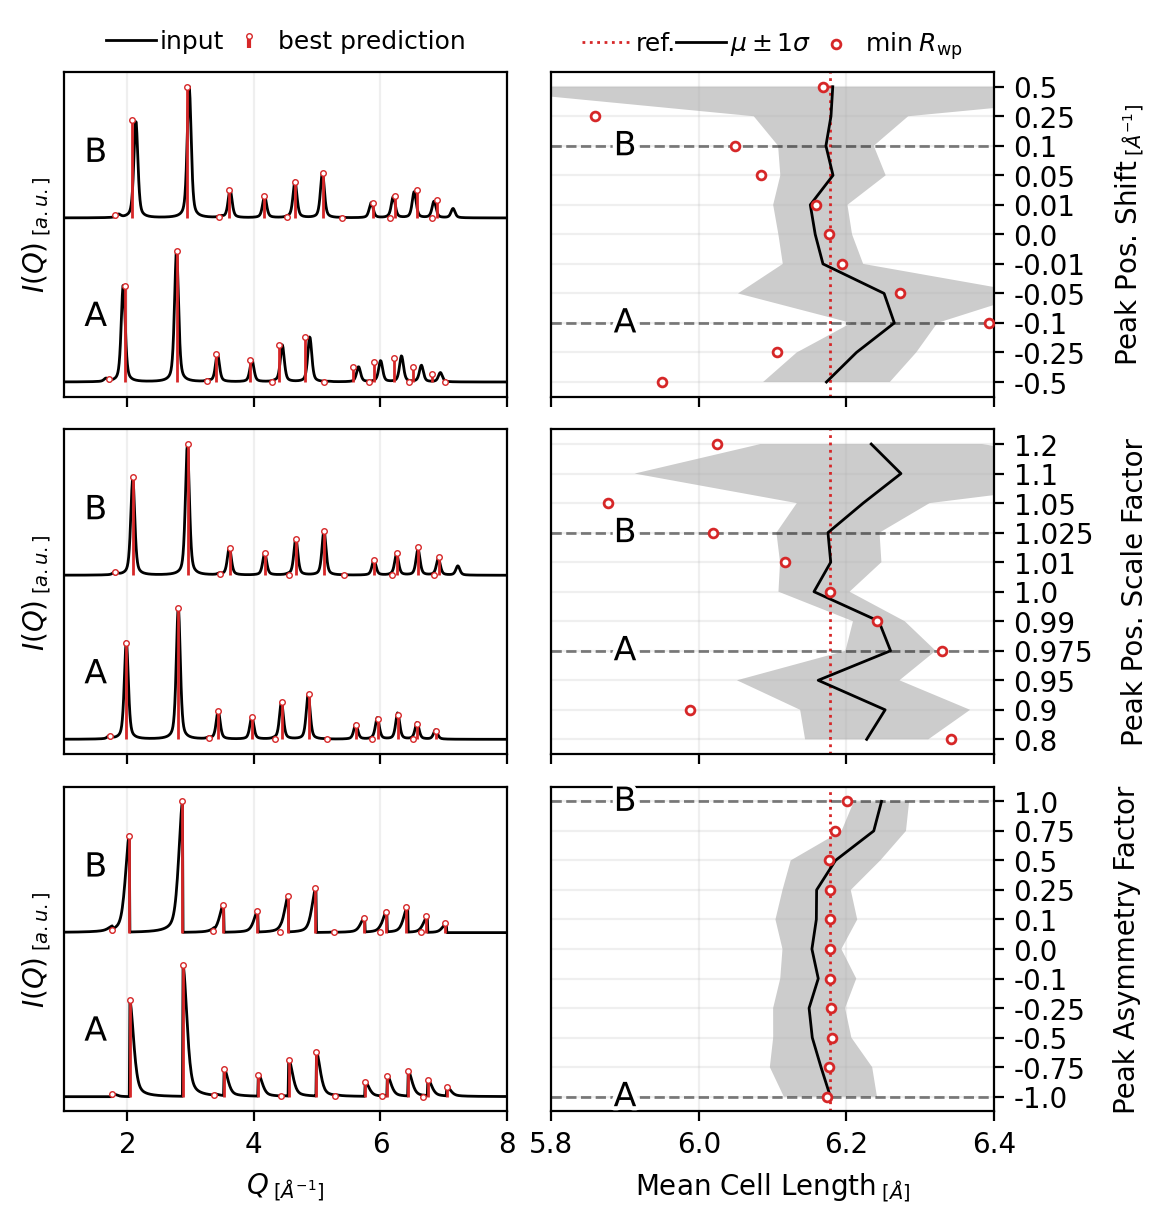

In [334]:
param_keys = [
    {
        "key": "q_shift", 
        "title": "Peak Pos. Shift", 
        "xlabel": "Peak Pos. Shift", 
        "unit": r"$_{\;[Å^{-1}]}$", 
        "example_1_idx": 2,
        "example_2_idx": 8,
        "example_none_idx": 5,
        "param_symbol_top": r"$\lhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\rhd\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "q_scale", 
        "title": "Peak Pos. Scaling", 
        "xlabel": "Peak Pos. Scale Factor", 
        "unit": "", 
        "example_1_idx": 3, 
        "example_2_idx": 7,
        "example_none_idx": 5,
        "param_symbol_top": r"$\rhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\lhd\;\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "peak_asymmetry", 
        "title": "Peak Asymmetry", 
        "xlabel": "Peak Asymmetry Factor", 
        "unit": "", 
        "example_1_idx": 0, 
        "example_2_idx": 10,
        "example_none_idx": 5,
        "param_symbol_top": r"$/\!|$",
        "param_symbol_top_rot": 18.5,
        "param_symbol_bot": r"$|\!\backslash$",
        "param_symbol_bot_rot": -18.5,
        "param_symbol_size": 20
    },
]

ablation_figure_compact(param_keys, "ablation_1.png")

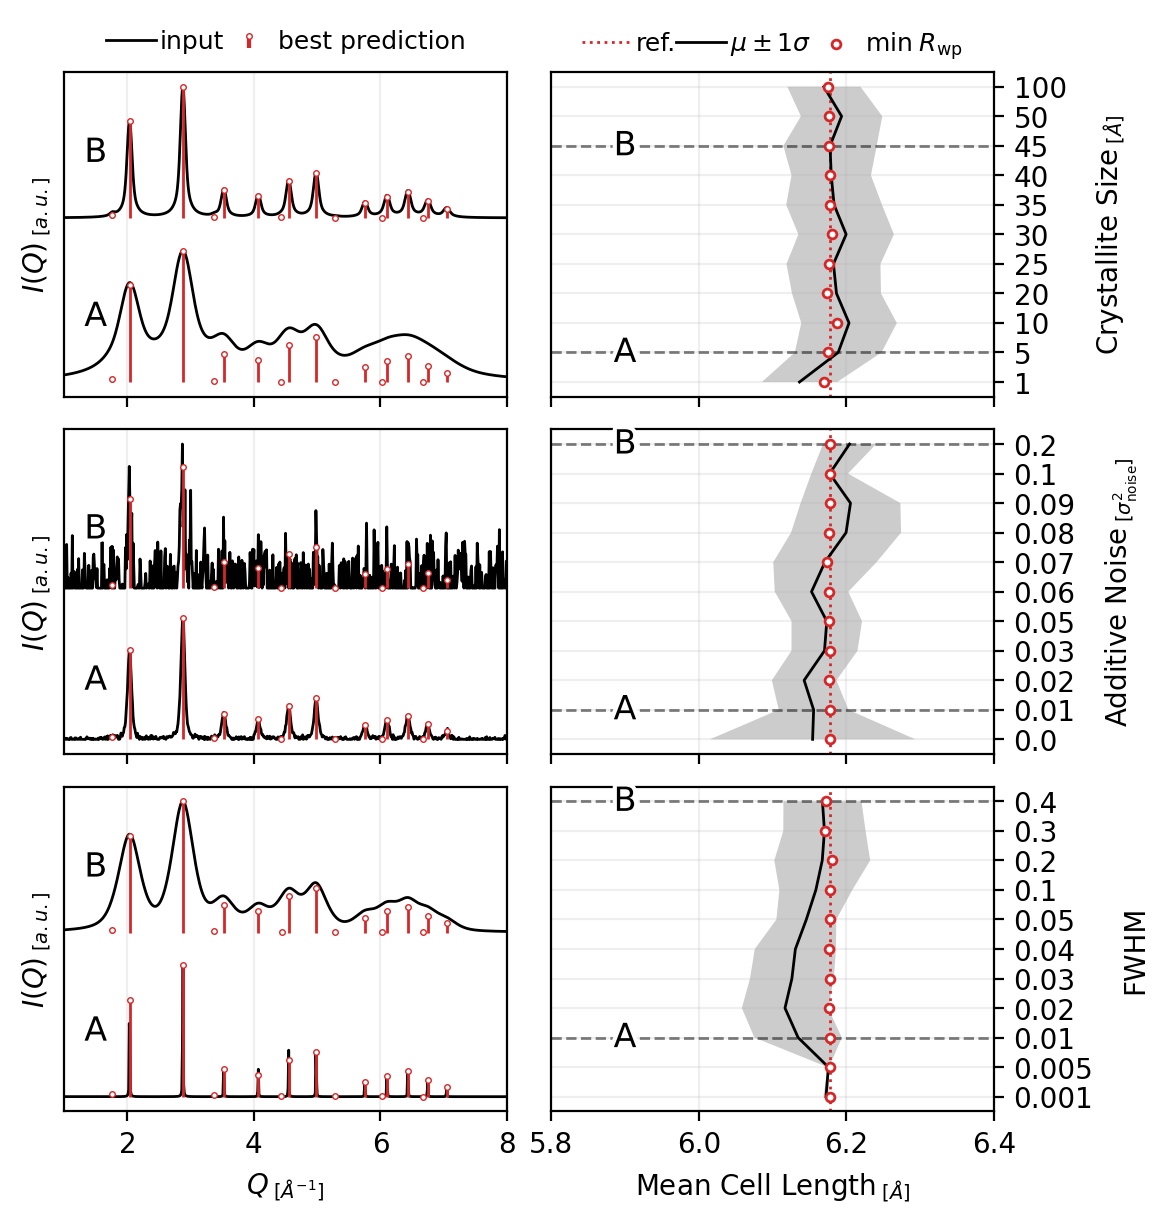

In [333]:

param_keys = [
    {
        "key": "particle_size", 
        "title": "Crystallite Size", 
        "xlabel": "Crystallite Size", 
        "unit": r"$_{\;[Å]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 8,
        "example_none_idx": 2,
        "param_symbol_top": r"o",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "noise", 
        "title": "Gaussian Noise", 
        "xlabel": "Additive Noise", 
        "unit": r"$_{\;[\sigma_{\mathrm{noise}}^2]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 10,
        "example_none_idx": 5,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "base_fwhm", 
        "title": "Instrumental Broadening", 
        "xlabel": "FWHM", 
        "unit": "", 
        "example_1_idx": 2, 
        "example_2_idx": 10,
        "example_none_idx": 5,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_figure_compact(param_keys, "ablation_2.png")